# High-mountain Asia Glacier Mass Balance

Companion notebook for analysis and figure generation for:

## A systematic, regional assessment of High-Mountain Asia glacier mass balance
### Shean et al. (2019), Frontiers in Earth Science

In [8]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%autoreload 2

In [10]:
#%matplotlib notebook
%matplotlib inline

In [11]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

import scipy.stats

from osgeo import gdal

from imview.lib import pltlib
from pygeotools.lib import iolib, geolib, malib

import geopandas as gpd
import cartopy.crs as ccrs 

In [12]:
#Default pandas options
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 500)

In [13]:
#Default matplotlib options
plt_opt = {'dpi':300, 'bbox_inches':'tight', 'pad_inches':0}

In [14]:
def cartopy_extent(extent):
    return [extent[0], extent[2], extent[1], extent[3]]

def append_centroid_xy(df):
    xlist = []
    ylist = []
    for index, row in df.centroid.iteritems():
        xlist.append(row.x)
        ylist.append(row.y)
    df['centroid_x'] = xlist
    df['centroid_y'] = ylist

In [15]:
#Root sum of squared errors
def rss(a, c=0.0):
    #return ((a**2).sum() + c*a.prod())**0.5
    return ((a**2).sum())**0.5

#Root mean squared errors
def rms(a):
    return ((a**2).mean())**0.5

In [16]:
#Define aggregation function for the dissolve
def aggregate(glac_df, glac_df_mb, col):
    aggfunc = {'area_m2':[np.mean, np.sum], \
               'mb_mwea':[np.mean, np.median, np.std, np.sum, np.size], \
               'mb_mwea_sigma':[np.mean, np.sum, rss], \
               'mb_m3wea':[np.mean, np.median, np.sum], \
               'mb_m3wea_sigma':[np.mean, np.sum, rss, rms], \
               'mb_Gta':[np.sum], \
               'mb_Gta_sigma':[np.mean, np.sum, rss, rms], \
               'Area':[np.mean, np.sum], \
               't1':[np.mean, np.min, np.max], \
               't2':[np.mean, np.min, np.max], \
               'dt':[np.mean, np.min, np.max], \
               'z_med':[np.mean, np.median, np.min, np.max]}
    
    #This is for all glaciers - mostly just to get total area
    glac_df_agg_sum = glac_df.groupby(col).sum()
    glac_df_agg_mean = glac_df.groupby(col).mean()
    #glac_df_agg_mean = glac_df.groupby(col).median()
    #Perform the aggregation
    glac_df_mb_agg = glac_df_mb.groupby(col).agg(aggfunc)
    
    #This is count of number of glaciers
    glac_df_mb_agg[('mb_mwea', 'count')] = glac_df_mb_agg[('mb_mwea', 'size')].astype('int64')
    
    #Sigma for ('mb_mwea','mean'), assumign errors are dependent is ('mb_mwea_sigma', 'mean') - sum of errors divided by n samples
    #Sigma for ('mb_mwea','mean'), assuming errors for each glacier are independent, with equal weight
    glac_df_mb_agg[('mb_mwea_sigma', 'rss_mean')] = glac_df_mb_agg[('mb_mwea_sigma', 'rss')]/glac_df_mb_agg[('mb_mwea', 'count')]
    
    #These are values for all glaciers in each region (not just those with mb numbers)
    glac_df_mb_agg[('Area_all', 'mean')] = glac_df_agg_mean['Area']
    glac_df_mb_agg[('Area_all', 'sum')] = glac_df_agg_sum['Area']
    
    #Percent coverage of mb numbers
    glac_df_mb_agg[('Area','perc')] = 100*glac_df_mb_agg[('Area','sum')]/glac_df_mb_agg[('Area_all', 'sum')]
    glac_df_mb_agg[('mb_mwea', 'total_m3a')] = glac_df_mb_agg[('mb_mwea', 'mean')] * glac_df_mb_agg[('Area_all', 'sum')] * 1E6
    glac_df_mb_agg[('mb_mwea', 'total_Gta')] = glac_df_mb_agg[('mb_mwea', 'total_m3a')]/1E9 
    
    #Gta and Gta_sigma estimate converted to m_wea
    glac_df_mb_agg[('mb_mwea', 'Gta_to_mwea')] = 1000*glac_df_mb_agg[('mb_Gta','sum')]/glac_df_mb_agg[('Area', 'sum')]
    glac_df_mb_agg[('mb_mwea_sigma', 'Gta_to_mwea')] = 1000*glac_df_mb_agg[('mb_Gta_sigma','sum')]/glac_df_mb_agg[('Area', 'sum')]
    
    #Cumulative numbers for full time period
    glac_df_mb_agg[('mb_mwe_cum', 'mean')] = glac_df_mb_agg[('mb_mwea','mean')] * glac_df_mb_agg[('dt', 'mean')]
    glac_df_mb_agg[('mb_mwe_cum', 'total_m3')] = glac_df_mb_agg[('mb_mwea', 'total_m3a')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('mb_mwe_cum', 'total_Gt')] = glac_df_mb_agg[('mb_mwea', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
   
    #Compute numbers for meltwater (polygons with mb < 0)
    #glac_df_mb_agg_meltwater = glac_df_mb[glac_df_mb['mb_mwea' < 0]].sum()
    glac_df_mb_agg_meltwater = glac_df_mb[glac_df_mb['mb_m3wea'] < 0].groupby(col).agg(aggfunc)
    glac_df_mb_agg[('meltwater', 'count')] = glac_df_mb_agg_meltwater[('mb_mwea', 'size')].astype('int64') 
    glac_df_mb_agg[('meltwater', 'total_m3a')] = glac_df_mb_agg_meltwater[('mb_m3wea', 'sum')]
    glac_df_mb_agg[('meltwater', 'total_m3a_sigma')] = glac_df_mb_agg_meltwater[('mb_m3wea_sigma', 'sum')]
    glac_df_mb_agg[('meltwater', 'total_Gta')] = glac_df_mb_agg[('meltwater', 'total_m3a')]/1E9 
    glac_df_mb_agg[('meltwater', 'total_Gta_sigma')] = glac_df_mb_agg[('meltwater', 'total_m3a_sigma')]/1E9
    glac_df_mb_agg[('meltwater', 'total_mmSLEa')] = glac_df_mb_agg[('meltwater', 'total_Gta')]/Gt2mm
    glac_df_mb_agg[('meltwater', 'total_mmSLEa_sigma')] = glac_df_mb_agg[('meltwater', 'total_Gta_sigma')]/Gt2mm
    
    #Cumulative meltwater numbers for full time period
    glac_df_mb_agg[('meltwater_cum', 'total_m3')] = glac_df_mb_agg[('meltwater', 'total_m3a')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('meltwater_cum', 'total_Gt')] = glac_df_mb_agg[('meltwater', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
    glac_df_mb_agg[('meltwater_cum', 'total_mmSLE')] = glac_df_mb_agg[('meltwater', 'total_Gta')] * glac_df_mb_agg[('dt', 'mean')] 
    return glac_df_mb_agg

In [17]:
def spatial_aggregate(glac_df, glac_df_mb, agg_df, col, sort=True):
    glac_df_mb_agg = aggregate(glac_df, glac_df_mb, col)
    append_centroid_xy(agg_df)
    if 'basin' in col:
        #Preserve basin attributes (endorheic flag, discharge)
        glac_df_mb_agg = glac_df_mb_agg.merge(agg_df[['ENDO', 'centroid_x', 'centroid_y']], left_index=True, right_index=True)
    else:
        glac_df_mb_agg = glac_df_mb_agg.merge(agg_df[['centroid_x', 'centroid_y']], left_index=True, right_index=True)
    if sort:
        glac_df_mb_agg.sort_values(by=('Area_all', 'sum'), ascending=False, inplace=True)
    glac_df_mb_agg.df_name = col
    return glac_df_mb_agg

In [18]:
def add_legend(ax, sf=16, loc='upper right'):
    """
    Create legend for scaled scatterplot markers
    """
    ax.autoscale(False)
    #CONUS
    #leg_s = np.array([0.1, 0.5, 1.0, 5.0, 10.0])
    #HMA
    #leg_s = np.array([0.1, 1.0, 10.0, 100.0])
    leg_s = np.array([1.0, 10.0, 100.0, 1000.0, 10000.0])
    #Spoof dummy coordinates way off map
    leg_x = np.full(leg_s.size, -999999999)
    leg_y = np.full(leg_s.size, -999999999)
    for i, s in enumerate(leg_s):
        #lbl = r'$%0.1f\/km^2$' % s
        lbl = '%i' % s
        ax.scatter(leg_x[i], leg_y[i], s=s*sf, c='gray', label=lbl)
    legend = ax.legend(title=r'$Glacier\/Area\/(km^2)$', scatterpoints=1, loc=loc, prop={'size':7}, ncol=leg_s.size)
    legend.get_title().set_fontsize('8')
    return legend

In [245]:
def load_hs(hs_fn):
    print("Loading shaded relief map")
    hs_ds = gdal.Open(hs_fn)
    hs = iolib.ds_getma(hs_ds)
    hs_clim = malib.calcperc(hs)
    hs_extent = geolib.ds_extent(hs_ds)
    hs_extent_cartopy = cartopy_extent(hs_extent)
    return hs, hs_ds, hs_clim, hs_extent_cartopy

def add_hs(hs, ax, hs_clim, hs_extent_cartopy):
    ax.autoscale(enable=False)
    ax.imshow(hs, cmap='gray', origin='upper', extent=hs_extent_cartopy, alpha=0.6, vmin=hs_clim[0], vmax=hs_clim[1])

In [252]:
def make_map(mb_dissolve_df=None, glac_df_mb=None, agg_df=None, col=('mb_mwea', 'mean'), sigma_col=None, \
             border_df=None, crs=None, extent=None, hs_bg=True, clim=None, \
             labels='val', title=None):

    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_aspect('equal')
    legend = add_legend(ax, sf=scaling_f)
    if title is not None:
        ax.set_title(title)

    if clim is None:
        #clim = (glac_df_mb[col].min(), glac_df_mb[col].max())
        clim = malib.calcperc_sym(mb_dissolve_df[col], perc=(1,99))

    cmap = 'RdBu'
    label = None
    if 'mb_mwea' in col:
        label = 'Mass Balance (m we/yr)'
    elif 'mb_mwea_sigma' in col:
        cmap = 'inferno'
        label = 'Mass Balance Uncertainty (m we/yr)'
    elif 'mb_Gta' in col: 
        label = 'Mass Balance (Gt/yr)'
    elif 'mb_Gta_sigma' in col:
        cmap = 'inferno'
        label = 'Mass Balance Uncertainty (Gt/yr)'
    elif 'meltwater_Gta' in col: 
        label = 'Excess Meltwater Runoff (Gt/yr)'
        #Reverse, as these are negative values
        cmap = 'YlOrRd_r'
        #cmap = 'inferno'
        clim = malib.calcperc(mb_dissolve_df[col], perc=(0,99))
    elif 't1' in col:
        cmap = 'inferno'
        label = 'Source Date (year)'

    #This is cartopy-enabled axes
    #ax = plt.axes(projection=crs)

    #Currently unsupported for AEA
    #gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    #if hs is not None:
    if hs_bg:
        print("Plotting image")
        #hs_style = {'cmap':'gray', 'origin':'upper', 'extent':cartopy_extent(hs_extent), 'transform':crs}
        #ax.imshow(hs, **hs_style)
        add_hs(hs, ax, hs_clim, hs_extent_cartopy)

    if border_df is not None:
        print("Plotting borders")
        border_style = {'facecolor':'0.65','edgecolor':'k', 'linewidth':0.7}
        #if hs is not None:
        if hs_bg:
            border_style = {'facecolor':'none','edgecolor':'k', 'linewidth':0.7}
        border_df.plot(ax=ax, **border_style)

    if False:
        if agg_df is not None:
            print("Plotting agg boundaries")
            #This provides colored regions
            #agg_style = {'cmap':'cpt_rainbow', 'edgecolor':'none', 'linewidth':0, 'alpha':0.05}
            agg_style = {'cmap':'summer', 'edgecolor':'none', 'linewidth':0, 'alpha':0.05}
            #agg_style = {'facecolor':'0.95','edgecolor':'k', 'linewidth':0.3, 'alpha':0.2}
            agg_df.plot(ax=ax, **agg_style)

    if glac_df_mb is not None:
        print("Plotting glacier polygons")
        glac_style = {'edgecolor':'k', 'linewidth':0.1, 'alpha':0.3}
        #This plots mb color ramp for each glacier polygon
        #glac_ax = glac_df_mb.plot(ax=ax, column=col[0], cmap=cmap, vmin=clim[0], vmax=clim[1], **glac_style)
        #This plots outlines
        glac_ax = glac_df_mb.plot(ax=ax, facecolor='none', **glac_style)

    if agg_df is not None:
        agg_style = {'facecolor':'none', 'edgecolor':'w', 'linewidth':0.5}
        agg_df.plot(ax=ax, **agg_style)

    #https://stackoverflow.com/questions/36008648/colorbar-on-geopandas
    # fake up the array of the scalar mappable so we can plot colorbar. Urgh...
    sc = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=clim[0], vmax=clim[1]))
    sc._A = []

    if mb_dissolve_df is not None:
        print("Plotting scatterplot of %s values" % (col, ))
        #Plot single values for region or basin
        x = mb_dissolve_df['centroid_x']
        y = mb_dissolve_df['centroid_y']
        #Scale by total glacier area in each polygon 
        if 'Area_all' in mb_dissolve_df:
            area_col = 'Area_all'
        elif ('Area_all', 'sum') in mb_dissolve_df:    
            area_col = ('Area_all', 'sum')
        elif ('Area_all', 'sum', 'sum') in mb_dissolve_df:
            area_col = ('Area_all', 'sum', 'sum')

        s = scaling_f*mb_dissolve_df[area_col]
        
        c = mb_dissolve_df[col]
        sc_style = {'cmap':cmap, 'edgecolor':'k', 'linewidth':0.5, 'alpha':0.8}
        sc = ax.scatter(x, y, s, c, vmin=clim[0], vmax=clim[1], **sc_style) 
        #Add labels
        text_kw = {'family':'sans-serif', 'fontsize':10, 'color':'k'}
        if labels is not None:
            print("Adding annotations")
            for k, v in mb_dissolve_df.iterrows():
                if 'sigma' in labels and sigma_col is not None:
                    if labels == 'val+sigma':
                        #sigma_col=('mb_Gta_sigma', 'sum', 'rss')
                        lbl = '%0.2f\u00b1%0.2f' % (v[col], v[sigma_col])
                    elif labels == 'name+val+sigma':
                        #sigma_col=('mb_Gta_sigma', 'sum', 'rss')
                        lbl = '%s\n%0.2f\u00b1%0.2f' % (k, v[col], v[sigma_col])
                else:
                    if 'name' in labels:
                        lbl = '%s\n%+0.2f' % (k, v[col])
                    else:
                        lbl = '%+0.2f' % v[col]
                #ax.annotate(lbl, xy=(v['centroid_x'],v['centroid_y']), xytext=(1,0), textcoords='offset points', family='sans-serif', fontsize=6, color='darkgreen')
                txt = ax.annotate(lbl, xy=(v['centroid_x'],v['centroid_y']), ha='center', va='center', **text_kw)
                txt.set_path_effects([path_effects.Stroke(linewidth=0.75, foreground='w'),path_effects.Normal()])

    #This is minx, miny, maxx, maxy
    if extent is None:
        #if glac_df_mb is not None:
        #    extent = glac_df_mb.total_bounds
        #else:
        extent = mb_dissolve_df.total_bounds

    #For cartopy axes
    #ax.set_extent(cartopy_extent(extent), crs=crs)
    #Pad extent so labels fit within map
    #extent = geolib.pad_extent(extent, perc=0.01, uniform=True)
    ax.set_xlim(extent[0], extent[2])
    ax.set_ylim(extent[1], extent[3])

    #Adding colorbar doesn't work with the cartopy axes
    pltlib.add_cbar(ax, sc, arr=mb_dissolve_df[col], label=label, clim=clim, format='%0.2f')
    pltlib.add_scalebar(ax, res=1, location='lower left')
    #pltlib.hide_ticks(ax)

    plt.tight_layout()
    plot_geo_grid(ax, in_proj=glac_crs)

    return fig

In [230]:
site = 'hma'
#site = 'conus'

area_filter = False
min_area_m2 = 1E6

outlier_removal = False

#Ocean area
#3.625×108 km2 (Cogley et al., 2011)
Gt2mm = 362.5

plot = True 
map_plots = True 

#Default mb clim
#mb_clim = (-1.0, 1.0)
#mb_clim = (-1.2, 1.2)
mb_clim = (-0.75, 0.75)

#suptitle = "Glacier Mass Balance (ASTER 2000–2009)"
#suptitle = "Glacier Mass Balance (ASTER 2000–2018)"
suptitle = "Glacier Mass Balance (ASTER+WV/GE 2000–2018)"
#suptitle = "Glacier Mass Balance (ASTER 2009–2018)"
#suptitle = "Glacier Mass Balance (SRTM 2000 to WV/GE median)"

#HMA
scaling_f = 0.2 
#CONUS
#scaling_f = 3 

rgi_col = 'RGIId'
kaab_region_col = 'kaab_region'
region_col = 'himap_region'
basin_col = 'HYBAS_ID'
#basin_col = 'basin_name'
qdgc_col = 'qdgc'
mascon_col = 'mascon'
hex_col = 'id'

extent = None
crs = None

#topdir = '/Users/dshean/data/'
topdir = '/scr/hma/hma_gmb_data'
#topdir = '/nobackup/deshean/data/hma_gmb_data'

if site == 'hma':
    #WBM basin names
    basin_col = 'basin_name'
    #hs_fn = os.path.join(topdir, 'hma_mos_32m_20180723/hma_mos_32m_100m_hs_az315.tif')
    hs_fn = '/scr/hma/TDM1_DEM_90m_hma_DEM_aea_4x_hs_az315.tif'
    glac_shp_fn = os.path.join(topdir, 'rgi60/regions/rgi60_merge_HMA_aea.shp')
    border_shp_fn = os.path.join(topdir, 'NaturalEarth/10m_cultural/10m_cultural/ne_10m_admin_0_countries_lakes.shp')
    #basin_shp_fn = os.path.join(topdir, 'basins/HydroBASINS/hybas_lake_as_lev01-12_v1c/hybas_lake_as_lev04_v1c.shp')
    basin_shp_fn = os.path.join(topdir, 'basins/HiMAT_full_210_IDs_subset_merged_clip_names_update.gpkg')
    kaab_region_shp_fn = os.path.join(topdir, 'regions/regions_from_kaab2015_merged_clean_20181111.gpkg')
    region_shp_fn = os.path.join(topdir, 'regions/boundary_mountain_regions_hma_v3_clean.gpkg')
    #http://www.mindland.com/wp/download-qdgc-continents/
    qdgc_shp_fn = os.path.join(topdir, 'qdgc/qdgc_01_asia.shp')
    mascon_shp_fn = os.path.join(topdir, 'mascons/GSFC.glb.200301_201607_v02.4_clip.gpkg')
    hex_shp_fn = os.path.join(topdir, 'hex/hma_25km_hexagons.gpkg')
    #This is geopandas crs format
    glac_crs = {u'datum':u'WGS84',u'lat_0':36,u'lat_1':25,u'lat_2':47,u'lon_0':85,u'no_defs':True,u'proj':u'aea',u'units':u'm',u'x_0':0,u'y_0':0}
    #minx, miny, maxx, maxy
    extent = [-1610900, -1142400, 1767400, 1145700]
elif site == 'conus':
    #hs_fn = '/scr/mb/gpd/conus_20171018_mos_32m_trans_100m_hs_az315_1km.tif'
    glac_shp_fn = os.path.join(topdir, 'rgi60/regions/rgi60_merge_CONUS_aea.shp')
    region_shp_fn = os.path.join(topdir, 'CONUS/regions/conus_mb_regions_aea.shp')
    border_shp_fn = os.path.join(topdir, 'NaturalEarth/10m_cultural/10m_cultural/ne_10m_admin_1_states_provinces_lakes.shp')
    basin_shp_fn = os.path.join(topdir, 'HydroBASINS/hybas_lake_na_lev01-12_v1c/hybas_lake_na_lev07_v1c.shp')
    glac_crs = {u'datum':u'WGS84',u'lat_0':43,u'lat_1':36,u'lat_2':49,u'lon_0':-115,u'no_defs':True,u'proj':u'aea',u'units':u'm',u'x_0':0,u'y_0':0}
    #This is cartopy
    crs = ccrs.AlbersEqualArea(central_longitude=-115, central_latitude=43, standard_parallels=(36, 49))
    extent = [-856800, -789000, 910700, 839400]
else:
    sys.exit("Site not currently supported")

In [25]:
def proc_rgi(glac_shp_fn, pointgeom=True):
    glac_df = gpd.read_file(glac_shp_fn)
    glac_df.shape
    glac_df.set_index(rgi_col, inplace=True)
    #Add centroid field - needed for proper partitioning in spatial join
    if pointgeom:
        glac_df['centroid_geom'] = gpd.GeoSeries(glac_df.centroid)
        glac_df['polygon_geom'] = gpd.GeoSeries(glac_df.geometry)
        glac_df.set_geometry('centroid_geom', inplace=True, drop=True)
    return glac_df

## Mass balance records
Input csv contains records for each RGI polygon, output of `mb_parallel.py` script

In [155]:
#Input csv from mb_parallel.py
#mb_csv_fn = sys.argv[1]

#mb_csv_fn = os.path.join(topdir, "mb/mb_20181108/ASTER_2000-2018/hma_mb_20181108_0454.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20181211/hma_mb_20181211_2117.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20181222/hma_mb_20181211_2117.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190207/hma_mb_20190207_0856.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190212/hma_mb_20190213_0143.csv")
#This is std
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190213/hma_mb_20190213_1924.csv")
#This is nmad
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190213_nmad/hma_mb_20190214_1015.csv")
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190213_nmad_hex/hma_mb_20190214_1015_nmad.csv")
mb_csv_fn = os.path.join(topdir, "mb/mb_combined_20190213_nmad/hma_mb_20190214_1015.csv")
#This is std + mean
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190213_std_sys/hma_mb_20190215_0815_std+mean.csv")
#Copy for hex analysis
#mb_csv_fn = os.path.join(topdir, "mb/mb_20190213_std_sys_hex/hma_mb_20190215_0815_std+mean.csv")
out_fn_suffix = '_hex_mb_combined'

In [78]:
#Test for no trend filtering
mb_csv_fn = os.path.join(topdir, "mb/mb_combined_20190908_nofltr/hma_mb_20190908_2044.csv")
out_fn_suffix = '_hex_mb_nofltr'
#Test for ASTER-only
#mb_csv_fn = os.path.join(topdir, "mb/mb_ASTERonly_20190910_fltr/hma_mb_20190910_1840.csv")
#out_fn_suffix = '_hex_mb_ASTER-only'

In [158]:
#driver = 'GeoJSON'
#ext = 'geojson'
#driver = 'ESRI Shapefile'
#ext = 'shp'
driver = 'GPKG'
ext= 'gpkg'

merge_fn = os.path.splitext(mb_csv_fn)[0]+'_'+os.path.splitext(os.path.split(glac_shp_fn)[-1])[0]+'.'+ext

glac_shp_join_fn = os.path.splitext(merge_fn)[0]+'_join.'+ext

if os.path.exists(glac_shp_join_fn):
    print("Loading glacier polygons joined with regions, basins, qdgc, mascons")
    glac_df = gpd.read_file(glac_shp_join_fn)
    #This is a hack, as geojson doesn't properly preserve custom aae proj
    glac_df.crs = glac_crs
else:
    print("Loading glacier polygons from RGI")
    glac_df = proc_rgi(glac_shp_fn)

#Area in km2
#glac_df.geometry.area.sum()/1E6
#glac_df['Area'].sum()

Loading glacier polygons joined with regions, basins, qdgc, mascons


In [159]:
if border_shp_fn is not None:
    print("Loading borders")
    #Load local copy of border polygons
    border_df = gpd.read_file(border_shp_fn)
    border_df = border_df.to_crs(glac_df.crs)

if kaab_region_shp_fn is not None:
    print("Loading Kaab regions")
    kaab_region_df = gpd.read_file(kaab_region_shp_fn)
    kaab_region_df.rename({'Nyainqentangla':'Nyainqentanglha', 'Pamir Alai':'Pamir Alay'}, inplace=True)
    #Convert to glac crs
    kaab_region_df = kaab_region_df.to_crs(glac_df.crs)
    kaab_region_df.set_index(kaab_region_col, inplace=True)

if region_shp_fn is not None:
    print("Loading regions")
    region_df = gpd.read_file(region_shp_fn)
    #Convert to glac crs
    region_df = region_df.to_crs(glac_df.crs)
    region_df.set_index(region_col, inplace=True)

if basin_shp_fn is not None:
    print("Loading basins")
    basin_df = gpd.read_file(basin_shp_fn)
    #There are issues with fiona writing large integers in basin IDs, convert to string to be safe
    #The dtype is int64, but finoa writes int32, and they all get truncated to 2147483647
    if basin_col == 'HYBAS_ID':
        for f in ['HYBAS_ID', 'NEXT_DOWN', 'NEXT_SINK', 'MAIN_BAS']:
            basin_df[f] = basin_df[f].astype('str')
    #Convert to glac crs
    basin_df = basin_df.to_crs(glac_df.crs)
    basin_df.set_index(basin_col, inplace=True)

if mascon_shp_fn is not None:
    print("Loading mascon")
    mascon_df = gpd.read_file(mascon_shp_fn)
    #Convert to glac crs
    mascon_df = mascon_df.to_crs(glac_df.crs)
    #Add a unique identifier
    mascon_df[mascon_col] = mascon_df.lat_center.map('{:,.0f}N'.format) + mascon_df.lon_center.map('{:,.0f}E'.format)
    mascon_df.set_index(mascon_col, inplace=True)

if qdgc_shp_fn is not None:
    print("Loading qdgc")
    qdgc_df = gpd.read_file(qdgc_shp_fn)
    #Convert to glac crs
    qdgc_df = qdgc_df.to_crs(glac_df.crs)
    qdgc_df.set_index(qdgc_col, inplace=True)
    
if hex_shp_fn is not None:
    print("Loading hex")
    hex_df = gpd.read_file(hex_shp_fn)
    #Convert to glac crs
    hex_df = hex_df.to_crs(glac_df.crs)
    hex_df.set_index(hex_col, inplace=True)

print(glac_df.shape)
#Add region, basin, etc fields to RGI polygons
if not os.path.exists(glac_shp_join_fn):
    if mascon_shp_fn is not None:
        print("One-time spatial join by mascon")
        glac_df = gpd.sjoin(glac_df, mascon_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':mascon_col}, inplace=True)
        print(glac_df.shape)

    if qdgc_shp_fn is not None:
        print("One-time spatial join by qdgc")
        glac_df = gpd.sjoin(glac_df, qdgc_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':qdgc_col}, inplace=True)
        print(glac_df.shape)
    
    if hex_shp_fn is not None:
        print("One-time spatial join by hex")
        glac_df = gpd.sjoin(glac_df, hex_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':hex_col}, inplace=True)
        print(glac_df.shape)

    if kaab_region_shp_fn is not None:
        print("One-time spatial join by Kaab region")
        glac_df = gpd.sjoin(glac_df, kaab_region_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':kaab_region_col}, inplace=True)
        print(glac_df.shape)
        
    if region_shp_fn is not None:
        print("One-time spatial join by region")
        glac_df = gpd.sjoin(glac_df, region_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':region_col}, inplace=True)
        print(glac_df.shape)

    if basin_shp_fn is not None:
        print("One-time spatial join by basin")
        glac_df = gpd.sjoin(glac_df, basin_df, how="inner", op="intersects")
        glac_df.rename(index=str, columns={'index_right':basin_col}, inplace=True)
        print(glac_df.shape)

    glac_df.set_geometry('polygon_geom', inplace=True, drop=True)
    print("Writing out: %s" % glac_shp_join_fn)
    #With index set to RGIId, it is not written out, hack to create new column
    glac_df.reset_index().rename(columns={'index':rgi_col}).to_file(glac_shp_join_fn, driver=driver)

Loading borders
Loading Kaab regions
Loading regions
Loading basins
Loading mascon
Loading qdgc
Loading hex
(94827, 47)


In [160]:
def load_mb(mb_csv_fn):
    print("Loading mb")
    mb_df = pd.read_csv(mb_csv_fn)
    mb_df[rgi_col] = 'RGI60-'+mb_df[rgi_col].map('{:08.5f}'.format)
    mb_df.set_index(rgi_col, inplace=True)
    mb_df['mb_Gta'] = mb_df['mb_m3wea']/1E9
    mb_df['mb_Gta_sigma'] = mb_df['mb_m3wea_sigma']/1E9

    #Update uncertainty for specific mass balance numbers
    #mb_df['mb_mwea_sigma_full'] = mb_df['mb_m3wea_sigma']/mb_df['area_m2']
    return mb_df

## Prepare mb data, join with RGI

In [161]:
mb_df_t1 = mb_df['t1'].mean()
mb_df_t2 = mb_df['t2'].mean()
print(mb_df_t1, mb_df_t2)
dt_str = '%.0f-%.0f' % (mb_df_t1, mb_df_t2)

#mb_df['mb_mwea_area'] = mb_df['mb_mwea'] * mb_df['area_km2']*1E6

if os.path.exists(merge_fn):
    print("Loading merged polygons and mb")
    glac_df_mb = gpd.read_file(merge_fn)
    glac_df_mb.set_index(rgi_col, inplace=True)
    print(glac_df_mb.shape)
else:
    print("Merging glacier polygons and mb results")
    glac_df_mb = glac_df.merge(mb_df, left_index=True, right_index=True)
    #With index set to RGIId, it is not written out, hack to create new column
    print(glac_df_mb.shape)
    print("Writing out: %s" % merge_fn)
    glac_df_mb.reset_index().rename(columns={'index':rgi_col}).to_file(merge_fn, driver=driver)

print("%i merged records loaded" % (glac_df_mb.shape[0]))

if area_filter:
    print("Filtering by glacier polygon area (min %0.2f km^2)" % (min_area_m2/1E6))
    orig_count = glac_df_mb.shape[0]
    glac_df_mb = glac_df_mb[glac_df_mb['area_m2'] > min_area_m2]
    print("%i of %i records preserved" % (glac_df_mb.shape[0], orig_count))

2000.4119999999998 2018.4119999999998
Loading merged polygons and mb
(94436, 72)
94436 merged records loaded


In [249]:
hs, hs_ds, hs_clim, hs_extent_cartopy = load_hs(hs_fn)

Loading shaded relief map


## Compare mb with and without spatial filter on dh/dt maps

In [162]:
mb_fltr_csv_fn = os.path.join(topdir, "mb/mb_combined_20190213_nmad/hma_mb_20190214_1015_nmad.csv")
mb_fltr = load_mb(mb_fltr_csv_fn)
mb_nofltr_csv_fn = os.path.join(topdir, "mb/mb_combined_20190908_nofltr/hma_mb_20190908_2044.csv")
mb_nofltr = load_mb(mb_nofltr_csv_fn)

Loading mb
Loading mb


In [163]:
mb_fltr.columns

Index(['x', 'y', 'z_med', 'z_min', 'z_max', 'z_slope', 'z_aspect', 'dhdt_ma',
       'dhdt_ma_sigma', 'mb_mwea', 'mb_mwea_sigma', 'area_m2', 'mb_m3wea',
       'mb_m3wea_sigma', 't1', 't2', 'dt', 'valid_area_perc', 'H_m',
       'debris_m', 'perc_debris', 'perc_pond', 'perc_clean', 'vm_ma', 'mb_Gta',
       'mb_Gta_sigma'],
      dtype='object')

In [164]:
#mb_diff = mb_fltr[['dhdt_ma','dhdt_ma_sigma']] - mb_nofltr[['dhdt_ma','dhdt_ma_sigma']]
mb_diff = mb_fltr - mb_nofltr

Text(0.5, 0, 'dh/dt uncertainty (m/yr)')

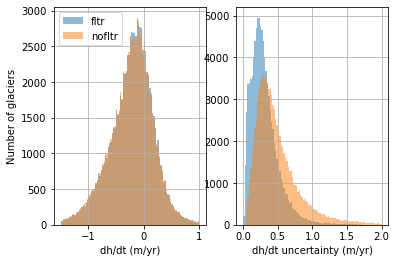

In [165]:
mb_hist_opt = {'bins':100, 'range':(-1.5, 1.0), 'alpha':0.5}
f,axa = plt.subplots(1,2)
mb_fltr['dhdt_ma'].hist(ax=axa[0], label='fltr', **mb_hist_opt)
mb_nofltr['dhdt_ma'].hist(ax=axa[0], label='nofltr', **mb_hist_opt)
mb_hist_opt['range'] = (0,2)
mb_fltr['dhdt_ma_sigma'].hist(ax=axa[1], label='fltr', **mb_hist_opt)
mb_nofltr['dhdt_ma_sigma'].hist(ax=axa[1], label='nofltr', **mb_hist_opt)
axa[0].legend()
axa[0].set_xlabel("dh/dt (m/yr)")
axa[0].set_ylabel("Number of glaciers")
axa[1].set_xlabel("dh/dt uncertainty (m/yr)")

Text(0.5, 0, 'Mass balance uncertainty (m w.e./yr)')

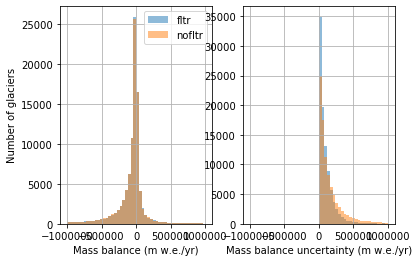

In [167]:
mb_hist_opt = {'bins':50, 'range':(-1E6,1E6),'alpha':0.5}
f,axa = plt.subplots(1,2)
mb_fltr['mb_m3wea'].hist(ax=axa[0], label='fltr', **mb_hist_opt)
mb_nofltr['mb_m3wea'].hist(ax=axa[0], label='nofltr', **mb_hist_opt)
#mb_hist_opt['range'] = (0,2)
mb_fltr['mb_m3wea_sigma'].hist(ax=axa[1], label='fltr', **mb_hist_opt)
mb_nofltr['mb_m3wea_sigma'].hist(ax=axa[1], label='nofltr', **mb_hist_opt)
axa[0].legend()
axa[0].set_xlabel("Mass balance (m w.e./yr)")
axa[0].set_ylabel("Number of glaciers")
axa[1].set_xlabel("Mass balance uncertainty (m w.e./yr)")

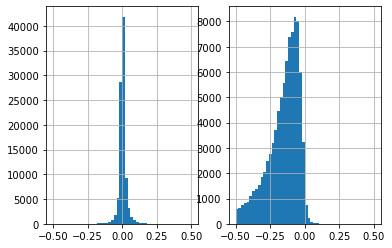

In [168]:
f,axa = plt.subplots(1,2)
mb_diff['dhdt_ma'].hist(ax=axa[0],bins=50, range=(-0.5, 0.5))
mb_diff['dhdt_ma_sigma'].hist(ax=axa[1],bins=50, range=(-0.5, 0.5))

## Evaluate percent of glacier polygon covered by dh/dt map

Text(0.5, 0, 'Percent of polygon with valid data')

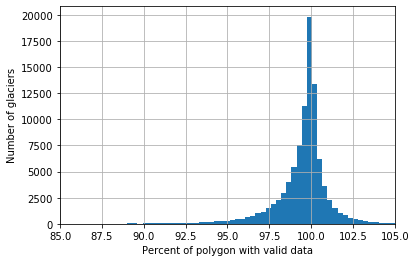

In [169]:
ax = mb_df['valid_area_perc'].hist(bins=128)
ax.set_xlim(85, 105)
ax.set_ylabel("Number of glaciers")
ax.set_xlabel("Percent of polygon with valid data")

In [170]:
#95th percentile of coverage
np.percentile(mb_df['valid_area_perc'], 5)

96.61990000000002

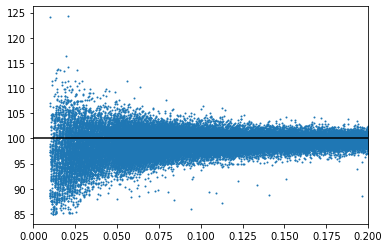

In [171]:
#Glacier area vs. percent coverage
f,ax = plt.subplots()
ax.scatter(mb_df['area_m2']/1E6, mb_df['valid_area_perc'], s=1)
ax.set_xlim(0,0.2)
ax.axhline(100,color='k')

## Final count of DEMs in each stack

In [72]:
#Generate text files from valid DEMs that were included in stacks
#cd /nobackupp8/deshean/hma/combined_aster_wv/dem_align_ASTER_WV_index_2000-2018_aea_stack
#parallel --progress 'wc -l {}/*fn_list.txt > {}/stack_count.txt' ::: 1*
#cat 1*/stack_count.txt > stack_count.txt

In [73]:
combined_count_fn = '/nobackupp8/deshean/hma/combined_aster_wv/dem_align_ASTER_WV_index_2000-2018_aea_stack/stack_count.txt'
aster_count_fn = '/nobackup/deshean/hma/aster/dsm/dem_align_ASTERonly/dem_align_ASTERonly_index_2000-2018_aea_stack/stack_count.txt'

In [74]:
def count_proc(count_fn):
    count_df = pd.read_csv(count_fn, sep=' ', names=['stack_count', 'stack_name'])
    count_df['RGIId'] = count_df['stack_name'].str.split('/',1).str[0]
    count_df.set_index('RGIId', inplace=True)
    return count_df

In [ ]:
combined_count_df = count_proc(combined_count_fn)
aster_count_df = count_proc(aster_count_fn)

In [68]:
combined_count_df['stack_count'].median()

35.0

In [67]:
aster_count_df['stack_count'].median()

33.0

Text(0, 0.5, 'Number of stacks')

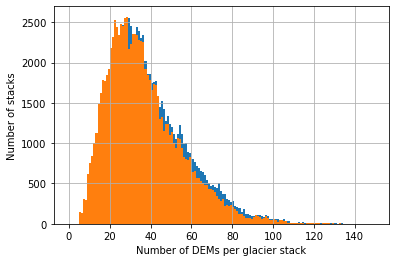

In [69]:
ax = combined_count_df['stack_count'].hist(bins=np.arange(0,150))
aster_count_df['stack_count'].hist(bins=np.arange(0,150))
ax.set_xlabel("Number of DEMs per glacier stack")
ax.set_ylabel("Number of stacks")

In [70]:
combined_count_df['aster_stack_count'] = aster_count_df['stack_count']

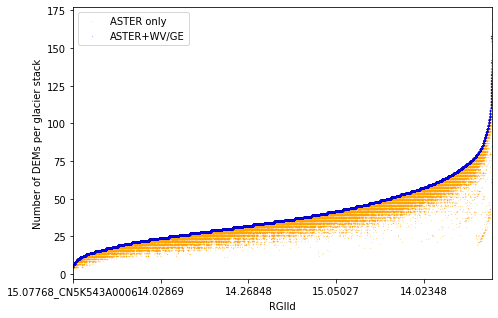

In [71]:
f,ax = plt.subplots(figsize=(7.5,5))
combined_count_df.sort_values(by='stack_count')['aster_stack_count'].plot(ax=ax, color='orange', lw=0, marker='.', ms=0.2, label='ASTER only')
combined_count_df.sort_values(by='stack_count')['stack_count'].plot(ax=ax, color='blue', lw=0, marker='.', ms=0.2, label='ASTER+WV/GE')
ax.set_ylabel("Number of DEMs per glacier stack")
plt.legend(loc='upper left')

In [72]:
combined_count_df['diff'] = combined_count_df['stack_count'] - combined_count_df['aster_stack_count']

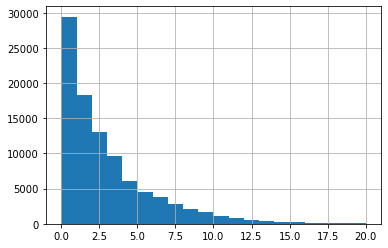

In [78]:
combined_count_df['diff'].hist(bins=20, range=(0,20))

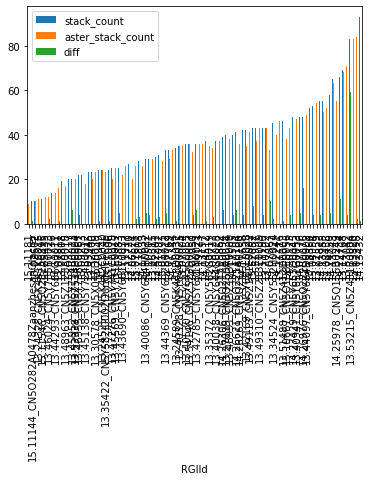

In [80]:
combined_count_df.sample(100).sort_values(by='stack_count').plot.bar()

## Total glacier area covered

In [172]:
#MB total area
mb_area = glac_df_mb.area.sum()/1E6
#RGI total area
rgi_area = glac_df['Area'].sum()
#rgi_area = glac_df.area.sum()/1E6
print('MB area: %0.2f km^2' % mb_area)
print('RGI area: %0.2f km^2' % rgi_area)
print('Percent coverage: %0.2f%%' % (100*mb_area/rgi_area))

MB area: 97002.70 km^2
RGI area: 97300.12 km^2
Percent coverage: 99.69%


In [173]:
#Total RGI glacier count
rgi_count = 95608 - 72 #some RGI 10 included in our gpkg
mb_count = glac_df_mb.shape[0]
print('MB count: %i' % mb_count)
print('RGI count: %i' % rgi_count)
print('Percent coverage: %0.2f%%' % (100*mb_count/rgi_count))

MB count: 94436
RGI count: 95536
Percent coverage: 98.85%


## Sort by area

In [174]:
glac_df_mb_sort = glac_df_mb.sort_values(by='area_m2', ascending=False)

(-2, 2)

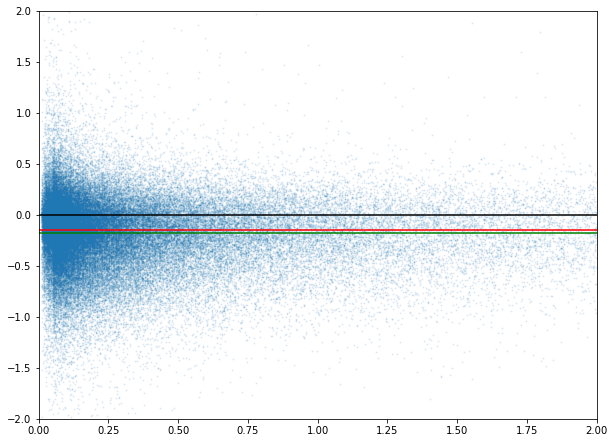

In [175]:
f,ax = plt.subplots(figsize=(10,7.5))
ax.scatter(glac_df_mb_sort['Area'], glac_df_mb_sort['mb_mwea'], s=1, alpha=0.1)
ax.axhline(0,c='k')
ax.axhline(glac_df_mb_sort['mb_mwea'].median(),c='r')
ax.axhline(glac_df_mb_sort['mb_mwea'].mean(),c='g')
ax.set_xlim(0,2)
ax.set_ylim(-2, 2)

(0, 100)

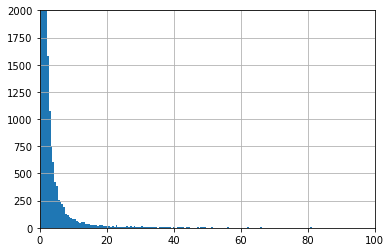

In [176]:
ax = glac_df_mb_sort['Area'].hist(bins=2000)
ax.set_ylim(0,2000)
ax.set_xlim(0,100)

# Spatial autocorrelation factor Acorf vs. glacier area A
A quick look at the coefficient used to scale area 

785398.1633974483


Text(0, 0.5, 'Acorf')

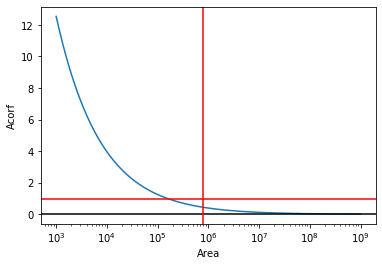

In [177]:
areaa = np.logspace(3, 9, 100)
L = 500
Acor = np.pi*(L**2)
print(Acor)
Acorf = np.sqrt(Acor/(5*areaa))
f,ax = plt.subplots()
ax.semilogx(areaa, Acorf)
ax.axhline(1.0, color='r')
ax.axhline(0.0, color='k')
ax.axvline(Acor, color='r')
ax.set_xlabel('Area')
ax.set_ylabel('Acorf')

## Binned mb by glacier polygon area

In [178]:
#bins=np.arange(0,500,1)
bins=np.logspace(-2,3,128)
bin_count, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb_sort['Area'], glac_df_mb_sort['mb_mwea'], statistic='count', bins=bins)
bin_mean, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb_sort['Area'], glac_df_mb_sort['mb_mwea'], statistic='mean', bins=bins)
bin_std, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb_sort['Area'], glac_df_mb_sort['mb_mwea'], statistic=np.std, bins=bins)
bin_median, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb_sort['Area'], glac_df_mb_sort['mb_mwea'], statistic='median', bins=bins)
#scipy.stats.median_absolute_deviation in version 1.3.0
bin_nmad, bin_edges, binnumber = scipy.stats.binned_statistic(glac_df_mb_sort['Area'], glac_df_mb_sort['mb_mwea'], statistic=malib.mad, bins=bins)

In [179]:
#bin_width = (bin_edges[1] - bin_edges[0])
#bin_centers = bin_edges[1:] - bin_width/2
bin_width = (bin_edges[:-1] - bin_edges[1:])
bin_centers = bin_edges[:-1] - bin_width/2

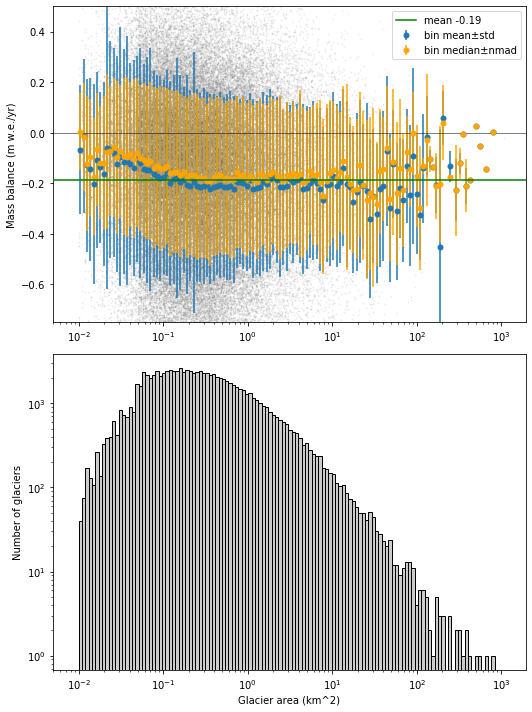

In [101]:
f,axa = plt.subplots(2, figsize=(7.5,10), sharex=True)
axa[0].scatter(glac_df_mb_sort['Area'], glac_df_mb_sort['mb_mwea'], s=1, c='0.5', alpha=0.1)
axa[0].errorbar(bin_centers, bin_mean, ls='none', yerr=bin_std, marker='o', markersize=5, label='bin mean\u00b1std')
axa[0].errorbar(bin_centers, bin_median, ls='none', c='orange', yerr=bin_nmad, marker='o', markersize=5, label='bin median\u00b1nmad')
axa[0].axhline(0,c='k',lw=0.5)
#axa[0].axhline(glac_df_mb_sort['mb_mwea'].median(),c='r')
axa[0].axhline(glac_df_mb_sort['mb_mwea'].mean(),c='g',zorder=999, label='mean %0.2f' % glac_df_mb_sort['mb_mwea'].mean())
axa[0].set_ylim(-0.75,0.5)
axa[1].bar(bin_centers, bin_count, width=bin_width, edgecolor='k', facecolor='0.8')
#axa[1].bar(bin_centers, bin_count, edgecolor='k')
axa[1].set_xlabel('Glacier area (km^2)')
axa[0].set_xscale('log')
axa[0].set_ylabel('Mass balance (m w.e./yr)')
axa[1].set_yscale('log')
axa[1].set_ylabel('Number of glaciers')
axa[0].legend()
#axa[1].set_ylim(0,10)
#axa[0].set_xlim(bins[0], bins[-1])
axa[0].xaxis.set_tick_params(which='both', labelbottom=True)
plt.tight_layout()
fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_area_v_mb.png'
f.savefig(fig_fn, **plt_opt)

## Consider total mb for small and large glaciers

In [180]:
area_thresh = 0.1 #km2
small_idx = glac_df_mb_sort['Area'] < area_thresh
big_idx = glac_df_mb_sort['Area'] >= area_thresh

In [181]:
print(glac_df_mb_sort['mb_mwea'][small_idx].mean())
print(glac_df_mb_sort['mb_mwea'][small_idx].median())
print(glac_df_mb_sort['mb_m3wea'][small_idx].sum()/1E9)
print(glac_df_mb_sort['Area'][small_idx].sum())

-0.13277917981072557
-0.105
-0.207105182449
1449.967


In [182]:
print(glac_df_mb_sort['mb_mwea'][big_idx].mean())
print(glac_df_mb_sort['mb_mwea'][big_idx].median())
print(glac_df_mb_sort['mb_m3wea'][big_idx].sum()/1E9)
print(glac_df_mb_sort['Area'][big_idx].sum())

-0.198897425278821
-0.16899999999999998
-18.768253666569
95552.817


In [183]:
mb_gt_lt = glac_df_mb_sort['Area'][small_idx].sum()*glac_df_mb_sort['mb_mwea'][small_idx].mean()/1000
mb_gt_lt

-0.19252542901261832

In [184]:
mb_gt_gt = glac_df_mb_sort['Area'][small_idx].sum()*glac_df_mb_sort['mb_mwea'][big_idx].mean()/1000
mb_gt_gt

-0.2883947030392563

In [185]:
# Difference in total mass balance (Gt/yr) if applying specific mass balance from larger glaciers to all glaciers under 0.1 km2
mb_gt_gt - mb_gt_lt

-0.09586927402663797

## Maps of glaciers binned by area

In [186]:
bins=np.logspace(-2,3,11)
bins

array([1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03])

In [187]:
df_cut = pd.cut(glac_df_mb_sort['Area'], bins)

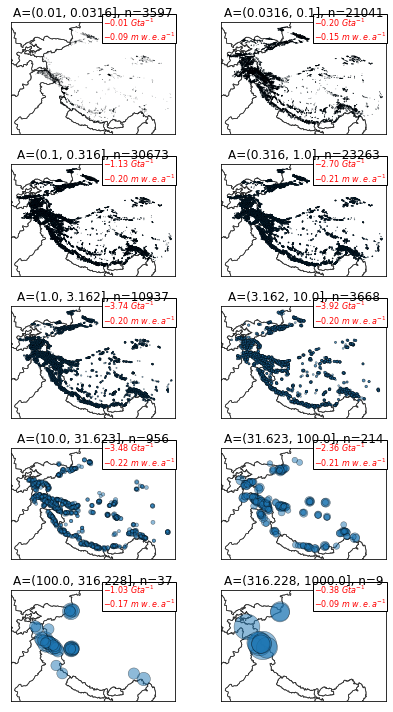

In [83]:
rc = (5,2)
f,axa = plt.subplots(*rc, figsize=(6,10), sharex=True, sharey=True)
axa = axa.ravel()

for n,i in enumerate(glac_df_mb_sort.groupby(df_cut)):
    border_df.plot(ax=axa[n], facecolor='none', edgecolor='0.2', lw=0.7)
    axa[n].scatter(i[1]['x'], i[1]['y'], s=i[1]['Area'], label=i[0], edgecolor='k', lw=0.5, alpha=0.5)
    axa[n].set_title('A=%s, n=%i' % (i[0], i[1].shape[0]))
    mb_gta = i[1]['mb_m3wea'].sum()/1E9
    mb_mwea = i[1]['mb_m3wea'].sum()/i[1]['area_m2'].sum()
    #mb_label = r'$%0.2f Gta^-1$' % mb_gta
    #axa[n].annotate(mb_label, xy=(0.05, 0.05), xycoords='axes fraction', color='r')
    mb_label = r'$%0.2f\ Gta^{-1}$' % mb_gta +'\n' + '$%0.2f\ m\ w.e.a^{-1}$' % mb_mwea
    #axa[n].annotate(mb_label, xy=(0.01, 0.06), xycoords='axes fraction', color='r', fontsize=8)
    axa[n].text(0.56, 0.84, mb_label, transform=axa[n].transAxes, color='r', fontsize=8, \
                bbox=dict(facecolor='white', alpha=1.0, edgecolor='k', pad=1.0))
    pltlib.hide_ticks(axa[n])

axa[0].set_xlim(extent[0], extent[2])
axa[0].set_ylim(extent[1], extent[3])
axa[0].set_aspect('equal')

plt.tight_layout()
#plt.suptitle("Spatial distribution of glaciers, binned by area (km2)")
fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_area_spatial.png'
f.savefig(fig_fn, **plt_opt)

In [84]:
i[1]['mb_m3wea'].sum()/i[1]['area_m2'].sum()

-0.08586631367961631

In [85]:
i[1].columns

Index(['GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'O1Region',
       'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax',
       'Status', 'Connect', 'Form', 'TermType', 'Surging', 'Linkages', 'Name',
       'geometry', 'mascon', 'area_deg', 'area_km2', 'basin', 'elev_flag',
       'lat_center', 'lat_span', 'location', 'lon_center', 'lon_span', 'qdgc',
       'lat', 'lon', 'areakm2', 'id', 'left', 'top', 'right', 'bottom',
       'kaab_region', 'himap_region', 'basin_name', 'DN', 'ENDO', 'x', 'y',
       'z_med', 'z_min', 'z_max', 'z_slope', 'z_aspect', 'dhdt_ma',
       'dhdt_ma_sigma', 'mb_mwea', 'mb_mwea_sigma', 'area_m2', 'mb_m3wea',
       'mb_m3wea_sigma', 't1', 't2', 'dt', 'valid_area_perc', 'H_m',
       'debris_m', 'perc_debris', 'perc_pond', 'perc_clean', 'vm_ma', 'mb_Gta',
       'mb_Gta_sigma'],
      dtype='object')

In [86]:
glac_df_mb_sort['mb_m3wea'].groupby(df_cut).agg('sum')/1E9

Area
(0.01, 0.0316]      -0.01
(0.0316, 0.1]       -0.20
(0.1, 0.316]        -1.13
(0.316, 1.0]        -2.70
(1.0, 3.162]        -3.74
(3.162, 10.0]       -3.92
(10.0, 31.623]      -3.48
(31.623, 100.0]     -2.36
(100.0, 316.228]    -1.03
(316.228, 1000.0]   -0.38
Name: mb_m3wea, dtype: float64

## RGI Polygon Date

In [188]:
rgi_decyear=glac_df_mb_sort['BgnDate'].astype(int)/10000
miny = np.floor(rgi_decyear.min())
maxy = np.ceil(rgi_decyear.max())

In [192]:
from pyproj import Proj, transform
from matplotlib.ticker import FormatStrFormatter

def plot_geo_grid(ax, lat_in=5, lon_in=5, in_proj={'init':'epsg:3857'}, fmt='%0.0f', grid=False):
    """
    plot geographic ticks/labels/grid on axes with projected coordinates
    Inputs are ax object, latitude interval, longitude interval
    """
    
    #ax.autoscale(enable=False)
    
    #Get input axes limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    #Define input and output projections
    in_proj = Proj(in_proj)
    out_proj = Proj(init='epsg:4326')

    #Get lat/lon coord for lower left and upper right mapped coords
    ll = transform(in_proj, out_proj, xlim[0], ylim[0])
    lr = transform(in_proj, out_proj, xlim[1], ylim[0])
    ul = transform(in_proj, out_proj, xlim[0], ylim[1])
    ur = transform(in_proj, out_proj, xlim[1], ylim[1])
    
    clat = np.mean([ll[1],lr[1],ul[1],ur[1]])
    clon = np.mean([ll[0],lr[0],ul[0],ur[0]])
    
    bottom_clat = np.mean([ll[1],lr[1]])
    top_clat = np.mean([ul[1],ur[1]])
    top_clon = np.mean([ul[0],ur[0]])
    left_clon = np.mean([ll[0],ul[0]])
    right_clon = np.mean([lr[0],ur[0]])
    
    #Get number of expected lat or lon intervals
    l_nx = np.floor((lr[0] - ll[0])/lon_in)
    u_nx = np.floor((ur[0] - ul[0])/lon_in)
    l_ny = np.floor((ul[1] - ll[1])/lat_in)
    r_ny = np.floor((ur[1] - lr[1])/lat_in)
    
    #Determine rounded lower left
    ll_r = np.zeros(2)
    ll_r[0] = np.ceil(ll[0]/lon_in) * lon_in 
    ll_r[1] = np.ceil(ll[1]/lat_in) * lat_in 
    ul_r = np.zeros(2)
    ul_r[0] = np.ceil(ul[0]/lon_in) * lon_in 
    ul_r[1] = np.floor(ul[1]/lat_in) * lat_in 
    lr_r = np.zeros(2)
    lr_r[0] = np.floor(lr[0]/lon_in) * lon_in 
    lr_r[1] = np.ceil(lr[1]/lat_in) * lat_in 
    ur_r = np.zeros(2)
    ur_r[0] = np.floor(ur[0]/lon_in) * lon_in 
    ur_r[1] = np.floor(ur[1]/lat_in) * lat_in
    
    #Prepare lists of rounded coordinates at given intervals
    bottom_list = np.arange(ll_r[0], lr_r[0]+lon_in, lon_in)
    top_list = np.arange(ul_r[0], ur_r[0]+lon_in, lon_in)
    left_list = np.arange(ll_r[1], ul_r[1]+lat_in, lat_in)
    right_list = np.arange(lr_r[1], ur_r[1]+lat_in, lat_in)
    
    bottom_tick_loc_out = list(zip(bottom_list, np.repeat(bottom_clat, bottom_list.size)))
    top_tick_loc_out = list(zip(top_list, np.repeat(top_clat, top_list.size)))
    left_tick_loc_out = list(zip(np.repeat(left_clon, left_list.size), left_list))
    right_tick_loc_out = list(zip(np.repeat(right_clon, right_list.size), right_list))
    
    #Determine tick locations (in input crs) for the desired lat/lon coords
    bottom_tick_loc_init = np.array([transform(out_proj, in_proj, xy[0], xy[1])[0] for xy in bottom_tick_loc_out])
    top_tick_loc_init = np.array([transform(out_proj, in_proj, xy[0], xy[1])[0] for xy in top_tick_loc_out])
    left_tick_loc_init = np.array([transform(out_proj, in_proj, xy[0], xy[1])[1] for xy in left_tick_loc_out])
    right_tick_loc_init = np.array([transform(out_proj, in_proj, xy[0], xy[1])[1] for xy in right_tick_loc_out])
    
    verbose = False
    if verbose:
        print(bottom_list)
        print(bottom_tick_loc_out)
        print(left_list)
        print(left_tick_loc_out)
    
    #Set formatter
    #ax.xaxis.set_major_formatter(FormatStrFormatter(fmt))
    #ax.yaxis.set_major_formatter(FormatStrFormatter(fmt))
    
    #Prepare tick labels with desired format
    if True:
        #bottom_tick_labels = [fmt % x +'$^\circ$E' for x in bottom_list]
        #top_tick_labels = [fmt % x +'$^\circ$E' for x in top_list]
        #left_tick_labels = [fmt % y +'$^\circ$N' for y in left_list]
        #right_tick_labels = [fmt % y +'$^\circ$N' for y in right_list]
        bottom_tick_labels = [fmt % x for x in bottom_list]
        top_tick_labels = [fmt % x for x in top_list]
        left_tick_labels = [fmt % y for y in left_list]
        right_tick_labels = [fmt % y for y in right_list]
    else:
        bottom_tick_labels = bottom_list
        top_tick_labels = top_list
        left_tick_labels = left_list
        right_tick_labels = right_list
    
    #print(bottom_tick_labels)
    
    ax.set_xticks(bottom_tick_loc_init)
    ax.set_xticklabels(bottom_tick_labels, minor=False)
    ax.set_yticks(left_tick_loc_init)
    ax.set_yticklabels(left_tick_labels, minor=False)
    
    #m = lambda x: x * (top_list[-1] - top_list[0])/(top_tick_loc_init[-1] - top_tick_loc_init[0])
    #im = lambda x: x * (top_tick_loc_init[-1] - top_tick_loc_init[0])/(top_list[-1] - top_list[0])
    im = lambda x: (-top_clon + x) * ((xlim[1] - xlim[0])/(ur[0] - ul[0]))
    m = lambda x: top_clon + (x * ((ur[0] - ul[0])/(xlim[1] - xlim[0])))

    top=True
    right=False
    
    #This doesn't work, as it rescales data
    if True:
        #topax = ax.twiny()
        topax = ax.secondary_xaxis('top', functions=(m,im))
        #topax.set_aspect('equal')
        #topax.set_xlim(ax.get_xlim())
        #topax.set_ylim(ax.get_ylim())

        #topax.set_xticks(top_tick_loc_init)
        #print(topax.get_xticklabels())
        #print(top_tick_labels)
        #topax.set_xticklabels(top_tick_labels, minor=False)
        #topax.xaxis.set_major_formatter(FormatStrFormatter(fmt))
        #topax.xaxis.set_major_formatter(FormatStrFormatter(fmt +'$^\circ$E'))
        #ax.set_xlim(*xlim)
        #ax.set_ylim(*ylim)
    
    if False:
        fig = ax.get_figure()
        topax = fig.add_axes(ax.get_position())
        topax.set_aspect('equal')
        topax.patch.set_visible(False)
        
        topax.xaxis.tick_top()
        topax.set_xticks(top_tick_loc_init)
        topax.set_xticklabels(top_tick_labels, minor=False)
        if right:
            topax.yaxis.tick_right()
            topax.set_yticks(right_tick_loc_init)
            topax.set_yticklabels(right_tick_labels, minor=False)
        else:
            topax.yaxis.set_visible(False)
        topax.set_xlim(ax.get_xlim())
        topax.set_ylim(ax.get_ylim())
        topax.set_title(ax.get_title())
        ax.set_title(None)
        
    #ax.set_xlabel('Longitude')
    #ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude'+'$^\circ$E')
    ax.set_ylabel('Latitude'+'$^\circ$N')

    if grid:
        ax.grid(ls=':')

In [232]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

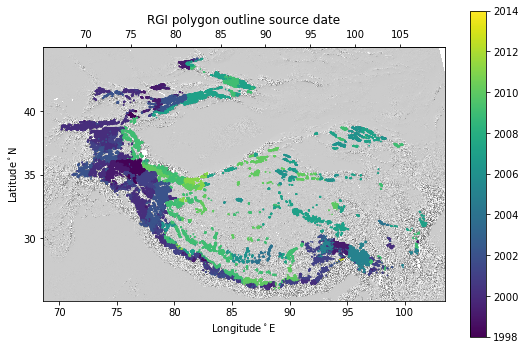

In [236]:
#RGI polygon date
f,ax = plt.subplots(figsize=(9,6))
sc = ax.scatter(glac_df_mb_sort['x'], glac_df_mb_sort['y'], c=rgi_decyear, s=0.5, vmin=miny, vmax=maxy)
plt.colorbar(sc)
ax.set_title("RGI polygon outline source date")
ax.set_aspect('equal', adjustable='box')
add_hs(hs, ax, hs_clim, hs_extent_cartopy)
plot_geo_grid(ax, in_proj=glac_crs)

#glac_df_mb_sort.plot.scatter(x='x', y='y', c='BgnDate')
rgi_date_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_RGI_sourceyear_fig.png'
f.savefig(rgi_date_fig_fn, **plt_opt)

In [194]:
# Check min/max mass numbers
rgi_idx = [glac_df_mb_sort['mb_m3wea'].idxmax(),]
rgi_idx.append(glac_df_mb_sort['mb_m3wea'].idxmin())
glac_df_mb_sort.loc[rgi_idx]

GLIMSId   BgnDate   EndDate  CenLon  CenLat O1Region  \
RGIId                                                                         
RGI60-14.04404  G075438E36192N  19980813  -9999999   75.44   36.19       14   
RGI60-15.11909  G096657E29334N  20050908  -9999999   96.66   29.33       15   

               O2Region   Area  Zmin  Zmax  Zmed  Slope  Aspect   Lmax  \
RGIId                                                                    
RGI60-14.04404        2 203.34  3314  7718  5391  23.60      21  31640   
RGI60-15.11909        3 179.59  3980  6341  5207  12.90      78  32403   

                Status  Connect  Form  TermType  Surging  Linkages  \
RGIId                                                                
RGI60-14.04404       0        0     0         0        3         9   
RGI60-15.11909       0        0     1         0        1         9   

                             Name  mascon  area_deg  area_km2    basin  \
RGIId                                                                    
RGI60-14.04404  Khurdopin Glacier  36N76E      1.00 12,373.54 5,051.00   
RGI60-15.11909            Yagnung  29N97E      1.00 12,406.28 5,035.00   

                elev_flag  lat_center  lat_span  location  lon_center  \
RGIId                                                                   
RGI60-14.04404       0.00       36.00      1.00     80.00       76.08   
RGI60-15.11909       0.00       29.00      1.00     80.00       96.88   

                lon_span      qdgc    lat    lon     areakm2     id  \
RGIId                                                                 
RGI60-14.04404      1.24  E075N36C  36.25  75.25  2493.27629   2985   
RGI60-15.11909      1.15  E096N29D  29.25  96.75  2693.48103  11025   

                       left         top        right      bottom  \
RGIId                                                              
RGI60-14.04404  -842,814.95   71,740.08  -813,947.44   46,740.08   
RGI60-15.11909 1,105,742.21 -678,259.92 1,134,609.72 -703,259.92   

                   kaab_region     himap_region   basin_name    DN  ENDO  \
RGIId                                                                      
RGI60-14.04404       Karakoram        Karakoram        Indus  5367     0   
RGI60-15.11909  Nyainqentangla  Nyainqentanglha  Brahmaputra    21     0   

                          x           y    z_med    z_min    z_max  z_slope  \
RGIId                                                                         
RGI60-14.04404  -838,312.43   62,425.23 5,369.00 3,295.32 7,510.49    15.66   
RGI60-15.11909 1,117,064.38 -685,115.41 5,166.14 3,921.18 6,317.99     9.99   

                z_aspect  dhdt_ma  dhdt_ma_sigma  mb_mwea  mb_mwea_sigma  \
RGIId                                                                      
RGI60-14.04404    143.91     0.23           0.01     0.20           0.06   
RGI60-15.11909    116.07    -1.30           0.01    -1.10           0.09   

                      area_m2        mb_m3wea  mb_m3wea_sigma       t1  \
RGIId                                                                    
RGI60-14.04404 203,335,845.65   39,691,132.12    5,224,127.20 2,000.41   
RGI60-15.11909 179,589,230.18 -198,383,836.77   24,336,811.74 2,000.41   

                     t2    dt  valid_area_perc    H_m  debris_m  perc_debris  \
RGIId                                                                          
RGI60-14.04404 2,018.41 18.00           100.00 142.66      0.18        15.82   
RGI60-15.11909 2,018.41 18.00            99.96 171.93      0.14        10.37   

                perc_pond  perc_clean  vm_ma  mb_Gta  mb_Gta_sigma  \
RGIId                                                                
RGI60-14.04404       0.45       83.72  53.99    0.04          0.01   
RGI60-15.11909       0.13       89.51  61.99   -0.20          0.02   

                                                         geometry  
RGIId                                                              
RGI60-14.04404  PO

In [195]:
#mb_m3wea_sigma_thresh = glac_df_mb_sort['mb_m3wea_sigma'].quantile(0.99)
#glac_df_mb_sort = glac_df_mb_sort[glac_df_mb_sort['mb_m3wea_sigma'] < mb_m3wea_sigma_thresh]

In [196]:
#Evaluate SNR
glac_df_mb_sort['SNR'] = glac_df_mb_sort['mb_m3wea'].abs()/glac_df_mb_sort['mb_m3wea_sigma']

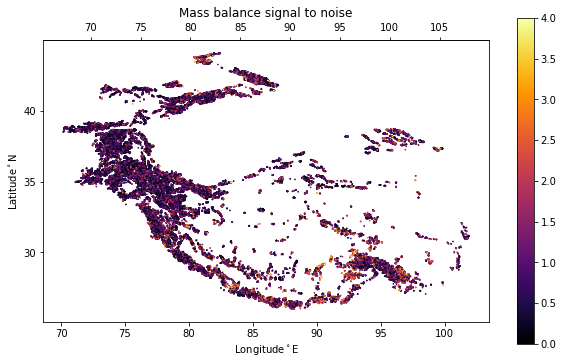

In [198]:
f,ax = plt.subplots(figsize=(10,6))
sc = ax.scatter(glac_df_mb_sort['x'], glac_df_mb_sort['y'], c=glac_df_mb_sort['SNR'], s=0.5, cmap='inferno', vmin=0, vmax=4)
plt.colorbar(sc)
ax.set_aspect('equal')
ax.set_title("Mass balance signal to noise")
plot_geo_grid(ax, in_proj=glac_crs)
#glac_df_mb_sort.plot.scatter(x='x', y='y', c='BgnDate')
#rgi_date_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_SNR_fig.png'
#f.savefig(rgi_date_fig_fn, **plt_opt)

(-10000000.0, 10000000.0)

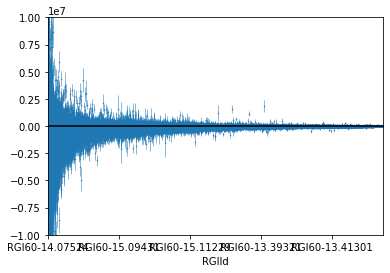

In [199]:
#Plot mb and error for all glaciers, sorted by area
f, ax = plt.subplots()
glac_df_mb_sort['mb_m3wea'].plot(marker='.', markersize=1, ls='none', lw=0.5, \
                                 yerr=glac_df_mb_sort['mb_m3wea_sigma'], ax=ax)
ax.axhline(0, color='k', zorder=99)
ax.set_ylim(-0.1E8, 0.1E8)

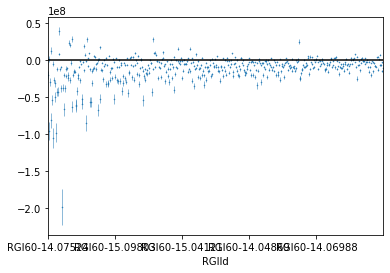

In [200]:
f, ax = plt.subplots()
cutoff = 500
glac_df_mb_sort['mb_m3wea'].head(cutoff).plot(marker='.', markersize=1, ls='none', lw=0.5, \
                                 yerr=glac_df_mb_sort['mb_m3wea_sigma'].head(cutoff), ax=ax)
ax.axhline(0, color='k', zorder=99)

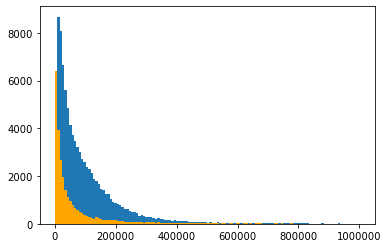

In [201]:
f, ax = plt.subplots()
asdf = ax.hist(glac_df_mb_sort['mb_m3wea_sigma'], bins=128, range=(0,1E6))
asdf = ax.hist(glac_df_mb_sort['mb_m3wea'], bins=128, range=(0,1E6), color='orange')
#mb_df['mb_m3wea'].hist(bins=128, range=(0,1E6),ax=ax)

In [202]:
idx = slice(0,100000)
print(glac_df_mb_sort['mb_m3wea'].iloc[idx].sum()/1E9)
print(rss(glac_df_mb_sort['mb_m3wea_sigma'].iloc[idx])/1E9)
print(glac_df_mb_sort['mb_m3wea_sigma'][idx].sum()/1E9)

-18.975358849018
0.08059568665708697
10.541023129204001


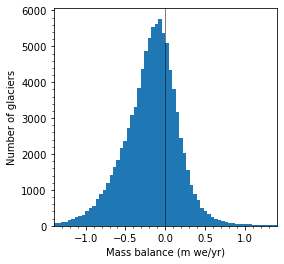

In [203]:
f, ax = plt.subplots(figsize=(4,4))
ax.set_xlabel('Mass balance (m we/yr)')
ax.set_ylabel('Number of glaciers')
hist_clim = (-1.4, 1.4)
ax.set_xlim(*hist_clim)
glac_df_mb['mb_mwea'].hist(range=hist_clim, bins=64, grid=False)
ax.axvline(0, lw=0.5, color='k')
ax.minorticks_on()

In [204]:
if outlier_removal:
    print("Removing outliers")

    #outlier_perc = (0.01, 0.99)
    outlier_perc = (0.001, 0.999)
    #outlier_clim = (glac_df_mb['mb_mwea'].quantile(outlier_perc[0]), glac_df_mb['mb_mwea'].quantile(outlier_perc[1]))
    std_f = 3.5
    #outlier_clim = glac_df_mb['mb_mwea'].mean() - std_f*glac_df_mb['mb_mwea'].std()
    outlier_clim = glac_df_mb['mb_mwea'].median() - std_f*malib.mad(glac_df_mb['mb_mwea'].values)
    outlier_clim = (outlier_clim, -outlier_clim)
    print("Removing outliers (%0.2f, %0.2f)" % (outlier_clim))
    #inlier_idx = np.abs(glac_df_mb['mb_mwea'] - glac_df_mb['mb_mwea'].mean()) <= (3*glac_df_mb['mb_mwea'].std())
    inlier_idx = (glac_df_mb['mb_mwea'] >= outlier_clim[0]) & (glac_df_mb['mb_mwea'] <= outlier_clim[1])

    print("%i records before outlier removal" % (glac_df_mb.shape[0]))
    glac_df_mb = glac_df_mb[inlier_idx]
    print("%i records after outlier removal" % (glac_df_mb.shape[0]))

    if False:
        glac_df_mb['mb_mwea'].hist(range=hist_clim, bins=256, label='After outlier filter')
        ax.axvline(0, linewidth=0.5, color='k')
        ax.legend()

In [205]:
test = aggregate(glac_df, glac_df_mb, 'Status')

In [206]:
test.T

Status                                              0
area_m2        mean                      1,027,179.23
               sum                  97,002,698,226.23
mb_mwea        mean                             -0.18
               median                           -0.15
               std                               0.38
               sum                         -17,169.20
               size                         94,436.00
mb_mwea_sigma  mean                              0.26
               sum                          24,907.88
               rss                              98.42
mb_m3wea       mean                       -200,933.53
               median                      -25,197.92
               sum                 -18,975,358,849.02
mb_m3wea_sigma mean                        111,620.81
               sum                  10,541,023,129.20
               rss                      80,595,686.66
               rms                         262,266.61
mb_Gta         sum                             -18.98
mb_Gta_sigma   mean                              0.00
               sum                              10.54
               rss                               0.08
               rms                               0.00
Area           mean                              1.03
               sum                          97,002.78
t1             mean                          2,000.41
               amin                          2,000.41
               amax                          2,000.41
t2             mean                          2,018.41
               amin                          2,018.41
               amax                          2,018.41
dt             mean                             18.00
               amin                             18.00
               amax                             18.00
z_med          mean                          5,055.50
               median                        5,163.87
               amin                          2,866.82
               amax                          7,821.87
mb_mwea        count                        94,436.00
mb_mwea_sigma  rss_mean                          0.00
Area_all       mean                              1.03
               sum                          97,300.12
Area           perc                             99.69
mb_mwea        total_m3a           -17,689,916,404.47
               total_Gta                       -17.69
               Gta_to_mwea                      -0.20
mb_mwea_sigma  Gta_to_mwea                       0.11
mb_mwe_cum     mean                             -3.27
               total_m3           -318,418,495,280.53
               total_Gt                       -318.42
meltwater      count                        66,567.00
               total_m3a           -22,735,706,832.68
               total_m3a_sigma       8,004,906,303.57
               total_Gta                       -22.74
               total_Gta_sigma                   8.00
               total_mmSLEa                     -0.06
               total_mmSLEa_sigma                0.02
meltwater_cum  total_m3           -409,242,722,988.28
               total_Gt                       -409.24
               total_mmSLE                    -409.24

In [207]:
glac_df_mb.describe()

CenLon    CenLat      Area      Zmin      Zmax      Zmed     Slope  \
count 94,436.00 94,436.00 94,436.00 94,436.00 94,436.00 94,436.00 94,436.00   
mean      81.11     35.52      1.03  4,856.40  5,307.79  5,082.02     25.91   
std        7.98      4.38      7.75    694.80    704.81    681.92      7.77   
min       67.48     27.49      0.01    521.00  1,141.00    610.00     -9.00   
25%       75.07     31.81      0.10  4,347.00  4,828.00  4,605.00     20.20   
50%       78.71     35.84      0.23  4,950.00  5,426.00  5,194.00     25.30   
75%       86.28     38.44      0.63  5,396.00  5,847.00  5,620.00     31.00   
max      103.15     45.35  1,077.96  7,624.00  8,799.00  7,828.00     69.50   

         Aspect      Lmax    Status   Connect      Form  TermType   Surging  \
count 94,436.00 94,436.00 94,436.00 94,436.00 94,436.00 94,436.00 94,436.00   
mean     171.64  1,220.09      0.00      0.00      0.02      0.00      7.20   
std      130.38  1,752.04      0.00      0.00      0.15      0.00      3.59   
min       -9.00     -9.00      0.00      0.00      0.00      0.00      0.00   
25%       40.00    432.00      0.00      0.00      0.00      0.00      9.00   
50%      156.00    728.00      0.00      0.00      0.00      0.00      9.00   
75%      311.00  1,355.00      0.00      0.00      0.00      0.00      9.00   
max      360.00 76,460.00      0.00      0.00      1.00      0.00      9.00   

       Linkages  area_deg  area_km2     basin  elev_flag  lat_center  \
count 94,436.00 94,436.00 94,436.00 94,436.00  94,436.00   94,436.00   
mean       8.93      1.00 12,391.12  5,245.26       0.00       35.52   
std        0.78      0.00     11.77    410.09       0.00        4.39   
min        0.00      1.00 12,373.54  5,004.00       0.00       27.00   
25%        9.00      1.00 12,380.52  5,007.00       0.00       32.00   
50%        9.00      1.00 12,392.33  5,035.00       0.00       36.00   
75%        9.00      1.00 12,401.62  5,051.00       0.00       38.00   
max        9.00      1.00 12,413.85  6,019.00       0.00       45.00   

       lat_span  location  lon_center  lon_span        id          left  \
count 94,436.00 94,436.00   94,436.00 94,436.00 94,436.00     94,436.00   
mean       1.00     80.00       81.11      1.24  5,042.48   -343,123.54   
std        0.00      0.00        7.99      0.07  2,931.72    711,088.43   
min        1.00     80.00       67.74      1.12    298.00 -1,492,334.00   
25%        1.00     80.00       74.85      1.18  2,811.00   -886,116.22   
50%        1.00     80.00       78.88      1.24  4,116.00   -561,356.69   
75%        1.00     80.00       85.98      1.27  6,871.00    109,812.99   
max        1.00     80.00      103.44      1.42 13,416.00  1,690,309.36   

               top         right       bottom        DN      ENDO  \
count    94,436.00     94,436.00    94,436.00 94,436.00 94,436.00   
mean     -6,430.58   -314,256.02   -31,430.58  4,299.33      0.52   
std     498,575.49    711,088.43   498,575.49  5,186.84      0.50   
min    -940,759.92 -1,463,466.49  -965,759.92     11.00      0.00   
25%    -428,259.92   -857,248.71  -453,259.92  1,270.00      0.00   
50%      34,240.08   -532,489.18     9,240.08  3,546.00      1.00   
75%     359,240.08    138,680.51   334,240.08  5,367.00      1.00   
max   1,071,740.08  1,719,176.87 1,046,740.08 26,369.00      1.00   

                  x            y     z_med     z_min     z_max   z_slope  \
count     94,436.00    94,436.00 94,436.00 94,436.00 94,436.00 94,436.00   
mean    -328,729.82   -18,918.09  5,055.50  4,830.32  5,292.32     26.87   
std      711,130.99   498,497.10    685.86    697.42    708.75      8.73   
min   -1,488,027.43  -950,447.98  2,866.82  2,289.59  3,050.73      2.03   
25%     -864,263.20  -438,552.40  4,585.75  4,328.88  4,816.29     20.18   
50%     -557,373.75    21,709.09  5,163.87  4,924.08  5,406.90     26.48   
75%      116,283.35   344,098.36  5,596.18  5,368.18  5,835.34     33.08   
max    1,694,017.64 1,058,598.

# Sampling for 25-km hexagon bins

In [208]:
if hex_shp_fn is not None:
    glac_df_mb_hex = spatial_aggregate(glac_df, glac_df_mb, hex_df, hex_col)

/Users/dshean/sw/miniconda3/envs/shean_py3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [209]:
#glac_gdf_mb_hex = gpd.GeoDataFrame(glac_df_mb_hex, geometry=hex_df.geometry)
from shapely.geometry import Point
hex_geom = [Point(p) for p in zip(glac_df_mb_hex['centroid_x'], glac_df_mb_hex['centroid_y'])]
glac_gdf_mb_hex = gpd.GeoDataFrame(glac_df_mb_hex, geometry=hex_geom)

In [210]:
#Note, some nan values for some columns here
glac_df_mb_hex.head()

(area_m2, mean)   (area_m2, sum)  (mb_mwea, mean)  (mb_mwea, median)  \
id                                                                           
3434    72,021,266.76 1,080,319,001.34            -0.07              -0.09   
3255    12,300,046.32   910,203,428.02             0.03               0.02   
1904    26,353,797.16   764,260,117.65            -0.03              -0.04   
2986    18,000,865.03   630,030,276.20            -0.08              -0.07   
2897     9,305,746.59   614,179,274.66            -0.08              -0.06   

      (mb_mwea, std)  (mb_mwea, sum)  (mb_mwea, size)  (mb_mwea_sigma, mean)  \
id                                                                             
3434            0.14           -1.08            15.00                   0.21   
3255            0.34            2.08            74.00                   0.33   
1904            0.17           -0.84            29.00                   0.24   
2986            0.47           -2.67            35.00                   0.37   
2897            0.22           -5.28            66.00                   0.29   

      (mb_mwea_sigma, sum)  (mb_mwea_sigma, rss)  (mb_m3wea, mean)  \
id                                                                   
3434                  3.11                  0.89     -1,321,198.82   
3255                 24.43                  3.40         87,838.03   
1904                  6.85                  1.47     -3,204,054.59   
2986                 12.89                  2.57     -1,056,121.04   
2897                 19.10                  2.69        114,579.89   

      (mb_m3wea, median)  (mb_m3wea, sum)  (mb_m3wea_sigma, mean)  \
id                                                                  
3434           -3,871.67   -19,817,982.27              384,108.26   
3255            3,180.16     6,500,014.03              162,636.54   
1904          -12,294.99   -92,917,583.03              532,240.62   
2986          -14,682.09   -36,964,236.45              243,235.52   
2897          -10,427.57     7,562,273.00              172,280.94   

      (mb_m3wea_sigma, sum)  (mb_m3wea_sigma, rss)  (mb_m3wea_sigma, rms)  \
id                                                                          
3434           5,761,623.90           5,369,394.75           1,386,371.76   
3255          12,035,103.68           4,576,280.15             531,981.76   
1904          15,434,978.11          12,179,049.64           2,261,592.74   
2986           8,513,243.14           4,998,436.84             844,890.03   
2897          11,370,541.87           4,724,259.72             581,516.17   

      (mb_Gta, sum)  (mb_Gta_sigma, mean)  (mb_Gta_sigma, sum)  \
id                                                               
3434          -0.02                  0.00                 0.01   
3255           0.01                  0.00                 0.01   
1904          -0.09                  0.00                 0.02   
2986          -0.04                  0.00                 0.01   
2897           0.01                  0.00                 0.01   

      (mb_Gta_sigma, rss)  (mb_Gta_sigma, rms)  (Area, mean)  (Area, sum)  \
id                                                                          
3434                 0.01                 0.00         72.02     1,080.32   
3255                 0.00                 0.00         12.30       910.21   
1904                 0.01                 0.00         26.35       764.26   
2986                 0.00                 0.00         18.00       630.03   
2897                 0.00                 0.00          9.31       614.18   

      (t1, mean)  (t1, amin)  (t1, amax)  (t2, mean)  (t2, amin)  (t2, amax)  \
id                                                                             
3434    2,000.41    2,000.41    2,000.41    2,018.41    2,018.41    2,018.41   
3255    2,000.41    2,000.41    2,000.41    2,018.41    2,018.41    2,018.41   
1904    2,000.41    2,000.41    2,000.41    2,018.41    2,01

In [211]:
#hma_stats = glac_df_mb_hex.mean(axis=0)
#hma_stats

In [212]:
#bins=np.arange(0,500,1)
bins=np.logspace(-2,3,128)
area = glac_df_mb_hex[('Area', 'sum')]
val = glac_df_mb_hex[('mb_mwea', 'Gta_to_mwea')]
#val = glac_df_mb_hex[('mb_mwea', 'mean')]
bin_count, bin_edges, binnumber = scipy.stats.binned_statistic(area, val, statistic='count', bins=bins)
bin_mean, bin_edges, binnumber = scipy.stats.binned_statistic(area, val, statistic='mean', bins=bins)
bin_std, bin_edges, binnumber = scipy.stats.binned_statistic(area, val, statistic=np.std, bins=bins)
bin_median, bin_edges, binnumber = scipy.stats.binned_statistic(area, val, statistic='median', bins=bins)
#scipy.stats.median_absolute_deviation in version 1.3.0
bin_nmad, bin_edges, binnumber = scipy.stats.binned_statistic(area, val, statistic=malib.mad, bins=bins)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

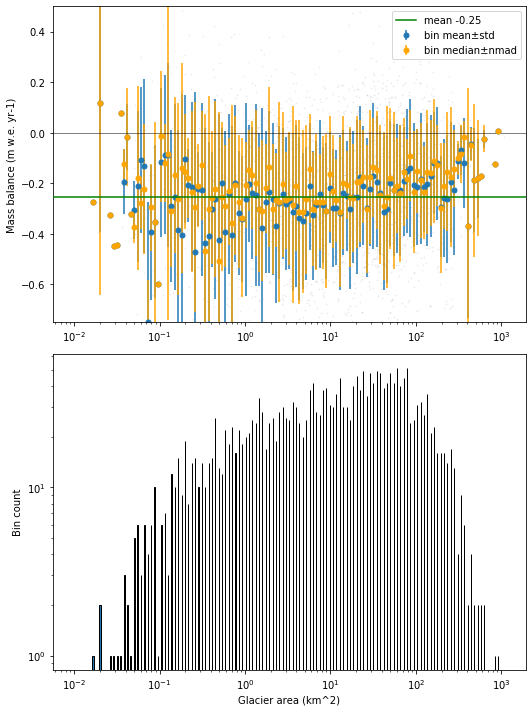

In [213]:
f,axa = plt.subplots(2, figsize=(7.5,10), sharex=True)
axa[0].scatter(area, val, s=1, c='0.5', alpha=0.1)
axa[0].errorbar(bin_centers, bin_mean, ls='none', yerr=bin_std, marker='o', markersize=5, label='bin mean\u00b1std')
axa[0].errorbar(bin_centers, bin_median, ls='none', c='orange', yerr=bin_nmad, marker='o', markersize=5, label='bin median\u00b1nmad')
axa[0].axhline(0,c='k',lw=0.5)
#axa[0].axhline(glac_df_mb_sort['mb_mwea'].median(),c='r')
axa[0].axhline(val.mean(),c='g',zorder=999, label='mean %0.2f' % val.mean())
axa[0].set_ylim(-0.75,0.5)
axa[1].bar(bin_centers, bin_count, width=bin_width, edgecolor='k')
axa[1].set_xlabel('Glacier area (km^2)')
axa[0].set_xscale('log')
axa[0].set_ylabel('Mass balance (m w.e. yr-1)')
axa[1].set_yscale('log')
axa[1].set_ylabel('Bin count')
axa[0].legend()
#axa[1].set_ylim(0,10)
#axa[0].set_xlim(bins[0], bins[-1])
axa[0].xaxis.set_tick_params(which='both', labelbottom=True)
plt.tight_layout()
#fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_area_v_mb.png'
#f.savefig(fig_fn, **plt_opt)

No handles with labels found to put in legend.


Text(0.5, 0.98, 'Spatial distribution of glaciers, binned by area (km2)')

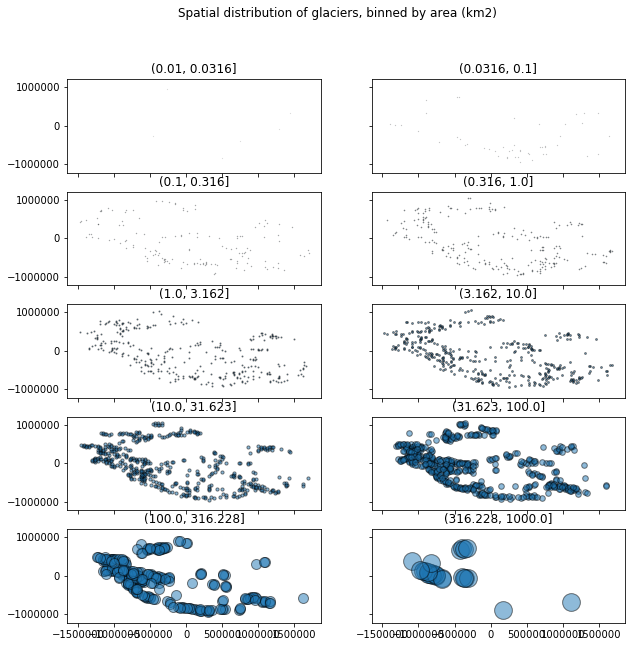

In [215]:
rc = (5,2)
bins=np.logspace(-2,3,11)
df_cut = pd.cut(area, bins)
f,axa = plt.subplots(*rc, figsize=(10,10), sharex=True, sharey=True)
axa = axa.ravel()
for n,i in enumerate(glac_df_mb_hex.groupby(df_cut)):
    axa[n].scatter(i[1]['centroid_x'], i[1]['centroid_y'], s=i[0].left, label=i[0], edgecolor='k', alpha=0.5)
    axa[n].set_title(i[0])
ax.legend()
plt.suptitle("Spatial distribution of glaciers, binned by area (km2)")
#fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_area_spatial.png'
#f.savefig(fig_fn, **plt_opt)

## HMA-wide numbers

In [216]:
glac_df_mb_hex.head()

(area_m2, mean)   (area_m2, sum)  (mb_mwea, mean)  (mb_mwea, median)  \
id                                                                           
3434    72,021,266.76 1,080,319,001.34            -0.07              -0.09   
3255    12,300,046.32   910,203,428.02             0.03               0.02   
1904    26,353,797.16   764,260,117.65            -0.03              -0.04   
2986    18,000,865.03   630,030,276.20            -0.08              -0.07   
2897     9,305,746.59   614,179,274.66            -0.08              -0.06   

      (mb_mwea, std)  (mb_mwea, sum)  (mb_mwea, size)  (mb_mwea_sigma, mean)  \
id                                                                             
3434            0.14           -1.08            15.00                   0.21   
3255            0.34            2.08            74.00                   0.33   
1904            0.17           -0.84            29.00                   0.24   
2986            0.47           -2.67            35.00                   0.37   
2897            0.22           -5.28            66.00                   0.29   

      (mb_mwea_sigma, sum)  (mb_mwea_sigma, rss)  (mb_m3wea, mean)  \
id                                                                   
3434                  3.11                  0.89     -1,321,198.82   
3255                 24.43                  3.40         87,838.03   
1904                  6.85                  1.47     -3,204,054.59   
2986                 12.89                  2.57     -1,056,121.04   
2897                 19.10                  2.69        114,579.89   

      (mb_m3wea, median)  (mb_m3wea, sum)  (mb_m3wea_sigma, mean)  \
id                                                                  
3434           -3,871.67   -19,817,982.27              384,108.26   
3255            3,180.16     6,500,014.03              162,636.54   
1904          -12,294.99   -92,917,583.03              532,240.62   
2986          -14,682.09   -36,964,236.45              243,235.52   
2897          -10,427.57     7,562,273.00              172,280.94   

      (mb_m3wea_sigma, sum)  (mb_m3wea_sigma, rss)  (mb_m3wea_sigma, rms)  \
id                                                                          
3434           5,761,623.90           5,369,394.75           1,386,371.76   
3255          12,035,103.68           4,576,280.15             531,981.76   
1904          15,434,978.11          12,179,049.64           2,261,592.74   
2986           8,513,243.14           4,998,436.84             844,890.03   
2897          11,370,541.87           4,724,259.72             581,516.17   

      (mb_Gta, sum)  (mb_Gta_sigma, mean)  (mb_Gta_sigma, sum)  \
id                                                               
3434          -0.02                  0.00                 0.01   
3255           0.01                  0.00                 0.01   
1904          -0.09                  0.00                 0.02   
2986          -0.04                  0.00                 0.01   
2897           0.01                  0.00                 0.01   

      (mb_Gta_sigma, rss)  (mb_Gta_sigma, rms)  (Area, mean)  (Area, sum)  \
id                                                                          
3434                 0.01                 0.00         72.02     1,080.32   
3255                 0.00                 0.00         12.30       910.21   
1904                 0.01                 0.00         26.35       764.26   
2986                 0.00                 0.00         18.00       630.03   
2897                 0.00                 0.00          9.31       614.18   

      (t1, mean)  (t1, amin)  (t1, amax)  (t2, mean)  (t2, amin)  (t2, amax)  \
id                                                                             
3434    2,000.41    2,000.41    2,000.41    2,018.41    2,018.41    2,018.41   
3255    2,000.41    2,000.41    2,000.41    2,018.41    2,018.41    2,018.41   
1904    2,000.41    2,000.41    2,000.41    2,018.41    2,01

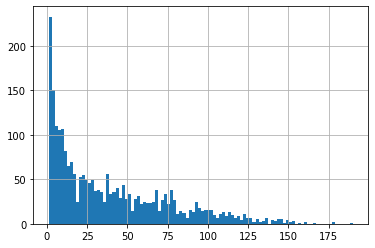

In [217]:
glac_df_mb_hex[('mb_mwea', 'size')].hist(bins=100)

In [218]:
print(glac_df_mb_hex[('mb_mwea', 'size')].mean())
print(glac_df_mb_hex[('mb_mwea', 'size')].min())
print(glac_df_mb_hex[('mb_mwea', 'size')].max())

38.990916597853015
1.0
190.0


In [219]:
#Sum of all hex samples - full region mb and uncertainty
hma_stats = glac_df_mb_hex.sum(axis=0)
hma_stats

(area_m2, mean)                   2,067,646,001.18
(area_m2, sum)                   97,002,698,226.23
(mb_mwea, mean)                            -517.52
(mb_mwea, median)                          -528.25
(mb_mwea, std)                              574.64
                                       ...        
(meltwater_cum, total_m3)      -409,242,722,988.28
(meltwater_cum, total_Gt)                  -409.24
(meltwater_cum, total_mmSLE)               -409.24
centroid_x                         -336,598,969.13
centroid_y                         -184,445,517.18
Length: 61, dtype: float64

In [220]:
print('%0.2f\u00b1%0.2f Gt/yr' % (hma_stats[('mb_Gta', 'sum')], hma_stats[('mb_Gta_sigma', 'rss')]))
print('%0.1f\u00b1%0.1f Gt/yr' % (hma_stats[('mb_Gta', 'sum')], hma_stats[('mb_Gta_sigma', 'rss')]))

-18.98±2.25 Gt/yr
-19.0±2.2 Gt/yr


In [221]:
print('%0.3f\u00b1%0.3f mmSLE/yr' % (hma_stats[('mb_Gta', 'sum')]/Gt2mm, hma_stats[('mb_Gta_sigma', 'rss')]/Gt2mm))

-0.052±0.006 mmSLE/yr


In [222]:
dt = 18.0
print('%0.3f\u00b1%0.3f mmSLE' % (dt*hma_stats[('mb_Gta', 'sum')]/Gt2mm, dt*hma_stats[('mb_Gta_sigma', 'rss')]/Gt2mm))

-0.942±0.112 mmSLE


In [223]:
print('%0.2f\u00b1%0.2f Gt' % (dt*hma_stats[('mb_Gta', 'sum')], dt*hma_stats[('mb_Gta_sigma', 'rss')]))

-341.56±40.42 Gt


In [224]:
hma_stats_m = 1000*hma_stats/hma_stats[('Area', 'sum')]
print('%0.2f\u00b1%0.2f m we/yr' % (hma_stats_m[('mb_Gta', 'sum')], hma_stats_m[('mb_Gta_sigma', 'rss')]))
print('%0.1f\u00b1%0.1f m we/yr' % (hma_stats_m[('mb_Gta', 'sum')], hma_stats_m[('mb_Gta_sigma', 'rss')]))

-0.20±0.02 m we/yr
-0.2±0.0 m we/yr


## Plot hex grids

In [261]:
title = suptitle + ": 25-km Hex Grid Cells"

In [262]:
scaling_f = 0.2

Plotting image
Plotting borders
Plotting scatterplot of ('mb_Gta', 'sum') values
Plotting image
Plotting borders
Plotting scatterplot of ('mb_Gta_sigma', 'sum') values


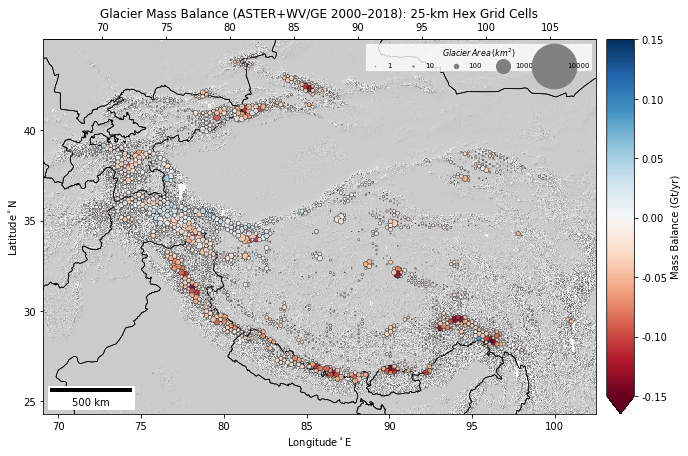

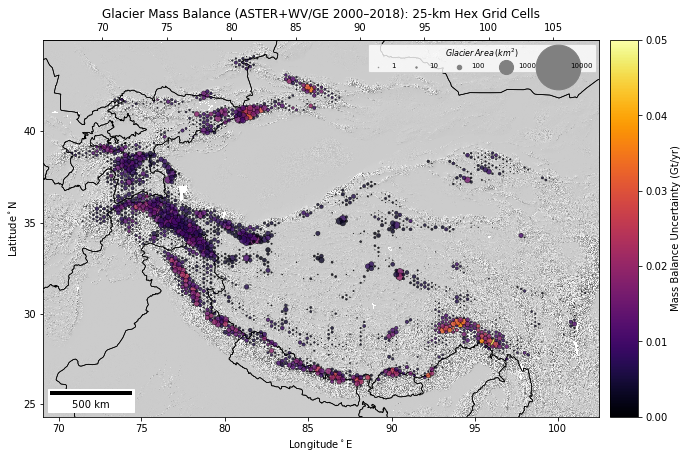

In [263]:
out_fn_suffix = '_hex_mb_Gta'
mb_gt_clim = (-0.15,0.15)
#hex_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_gt_clim, crs=crs, extent=extent, hs=hs, hs_extent_cartopy=hs_extent_cartopy, labels=None, title=title)
hex_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_gt_clim, crs=crs, extent=extent, hs_bg=True, labels=None, title=title)
hex_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
hex_fig.savefig(hex_fig_fn, **plt_opt)
mb_gt_sigma_clim = (0.00,0.05)
hex_sigma_fig = make_map(col=('mb_Gta_sigma', 'sum'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_gt_sigma_clim, crs=crs, extent=extent, labels=None, title=title)
hex_sigma_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_sigma.png'
hex_sigma_fig.savefig(hex_sigma_fig_fn, **plt_opt)

Plotting image
Plotting borders
Plotting scatterplot of ('mb_mwea', 'mean') values
Plotting image
Plotting borders
Plotting scatterplot of ('mb_mwea_sigma', 'mean') values


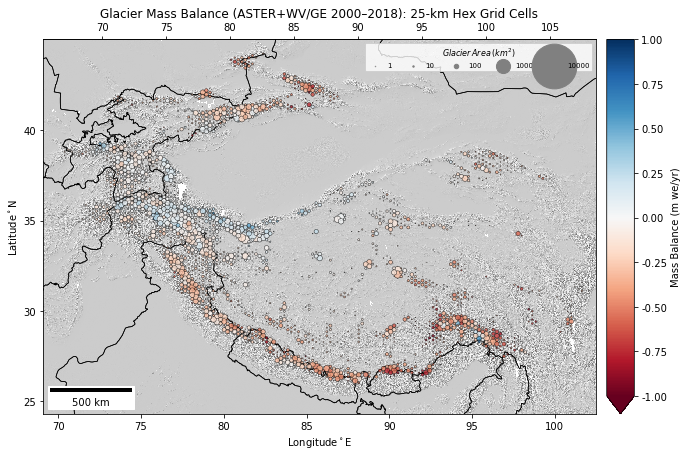

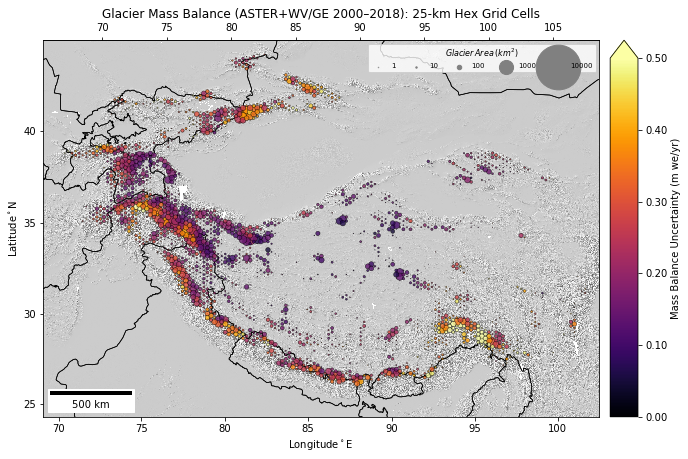

In [264]:
out_fn_suffix = '_hex_mb_mwea'
mb_mwea_clim = (-1.0,1.0)
hex_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_clim, crs=crs, extent=extent, labels=None, title=title)
hex_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
hex_fig.savefig(hex_fig_fn, **plt_opt)
mb_mwea_sigma_clim = (0,0.5)
hex_sigma_fig = make_map(col=('mb_mwea_sigma', 'mean'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_sigma_clim, crs=crs, extent=extent, labels=None, title=title)
hex_sigma_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_sigma.png'
hex_sigma_fig.savefig(hex_sigma_fig_fn, **plt_opt)

Plotting image
Plotting borders
Plotting scatterplot of ('mb_mwea', 'Gta_to_mwea') values
Plotting image
Plotting borders
Plotting scatterplot of ('mb_mwea_sigma', 'Gta_to_mwea') values


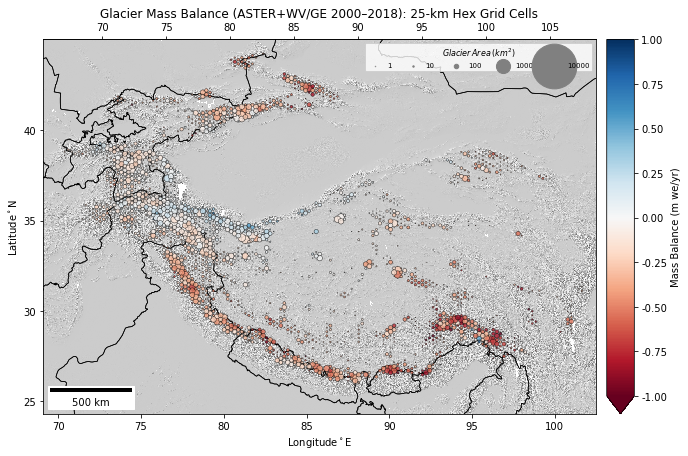

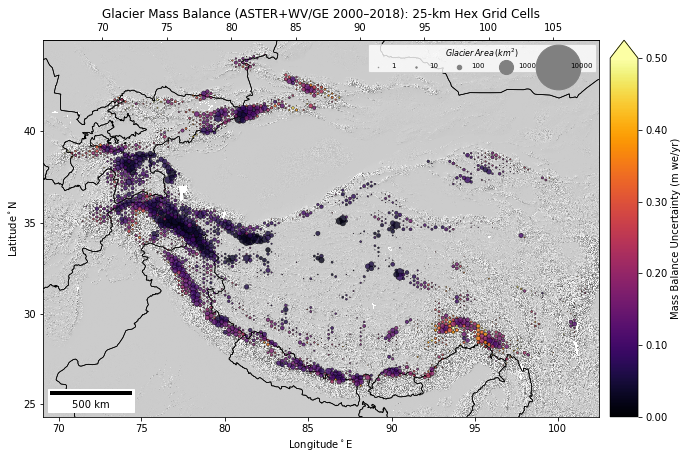

In [265]:
out_fn_suffix = '_hex_mb_Gta_to_mwea'
mb_mwea_clim = (-1.0,1.0)
hex_fig = make_map(col=('mb_mwea', 'Gta_to_mwea'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_clim, crs=crs, extent=extent, labels=None, title=title)
hex_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
hex_fig.savefig(hex_fig_fn, **plt_opt)
mb_mwea_sigma_clim = (0,0.5)
hex_sigma_fig = make_map(col=('mb_mwea_sigma', 'Gta_to_mwea'), mb_dissolve_df=glac_df_mb_hex, glac_df_mb=None, agg_df=None, border_df=border_df, clim=mb_mwea_sigma_clim, crs=crs, extent=extent, labels=None, title=title)
hex_sigma_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '_sigma.png'
hex_sigma_fig.savefig(hex_sigma_fig_fn, **plt_opt)

## Exploring mb vs elevation

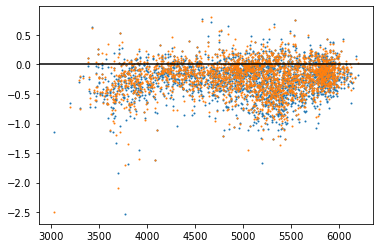

In [266]:
f,ax = plt.subplots()
z=glac_df_mb_hex[('z_med', 'median')]
mb=glac_df_mb_hex[('mb_mwea', 'Gta_to_mwea')]
mb2=glac_df_mb_hex[('mb_mwea', 'mean')]
#mb=glac_df_mb_hex[('mb_Gta', 'sum')]

ax.scatter(z,mb,s=1)
ax.scatter(z,mb2,s=1)
ax.axhline(0,c='k')
#ax.set_ylim(-0.1, 0.05)

In [267]:
def norm(a, percentile=(0.5, 99.5)):
    #amin, amax = (a.min(), a.max())
    amin, amax = np.nanpercentile(a, percentile)
    print(amin, amax)
    return ((a - amin)/(amax - amin))

-1.1475526289366629 0.47651632140634054
3425.31845 6092.043895


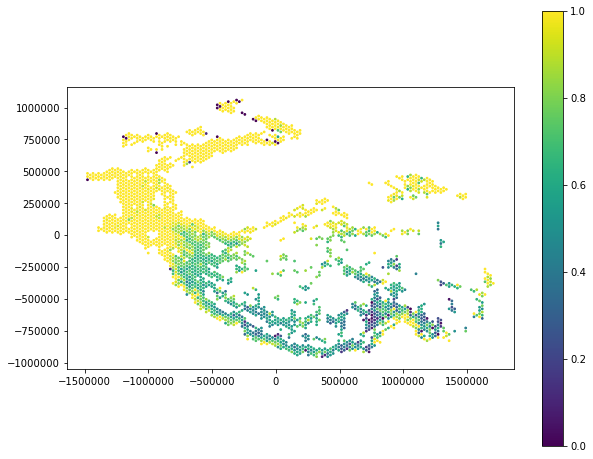

In [268]:
f,ax = plt.subplots(figsize=(10,8))
x=glac_df_mb_hex['centroid_x'].values
y=glac_df_mb_hex['centroid_y'].values
z=glac_df_mb_hex[('z_med', 'median')]
mb=glac_df_mb_hex[('mb_mwea', 'Gta_to_mwea')]
#mb=glac_df_mb_hex[('mb_mwea', 'mean')]
#asdf = norm(mb/z)
asdf = norm(mb)/norm(z)
clim=(0,1)
sc = ax.scatter(x,y,c=asdf,s=3,vmin=clim[0],vmax=clim[1])
plt.colorbar(sc)
ax.set_aspect('equal')

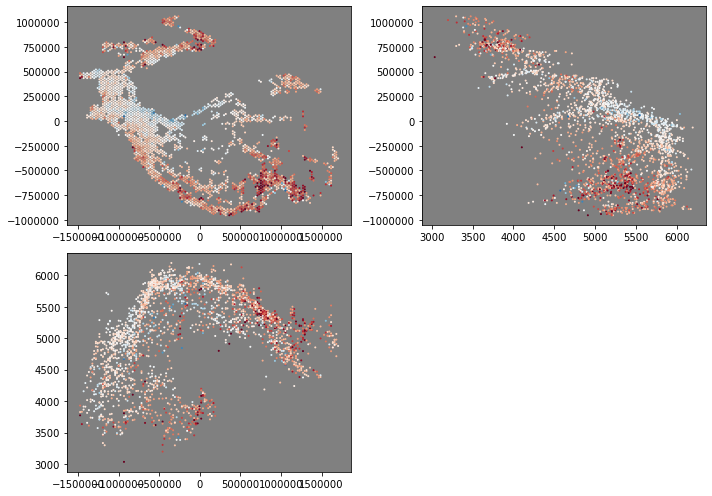

In [269]:
f,axa = plt.subplots(2,2,figsize=(10,7))
clim = (-1,1)
#axa[0][0].set_aspect('equal')
axa[0][0].scatter(x,y,c=mb,s=1,vmin=clim[0],vmax=clim[1],cmap='RdBu')
axa[1][0].scatter(x,z,c=mb,s=1,vmin=clim[0],vmax=clim[1],cmap='RdBu')
axa[0][1].scatter(z,y,c=mb,s=1,vmin=clim[0],vmax=clim[1],cmap='RdBu')
axa[1][1].axis('off')
plt.tight_layout()
for ax in axa.ravel():
    ax.set_facecolor('0.5')

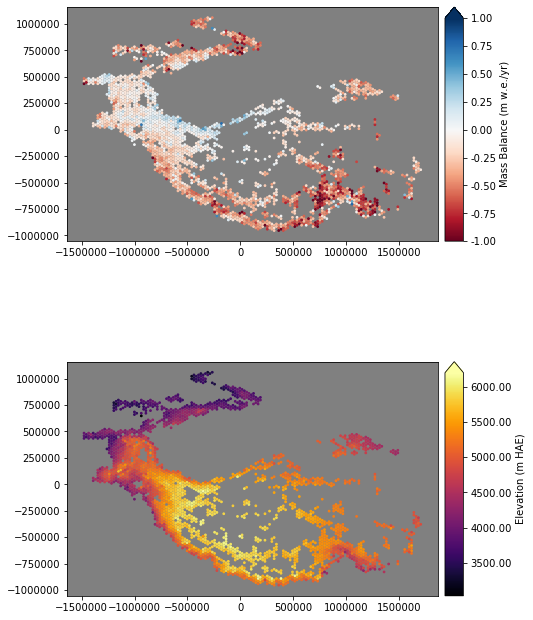

In [270]:
f,axa = plt.subplots(2, figsize=(7.5,10))
clim = (-1,1)
#axa[0][0].set_aspect('equal')
mb_m = axa[0].scatter(x,y,c=mb,s=3,vmin=clim[0],vmax=clim[1],cmap='RdBu')
z_m = axa[1].scatter(x,y,c=z,s=3,cmap='inferno')
pltlib.add_cbar(axa[0], mb_m, label='Mass Balance (m w.e./yr)')
pltlib.add_cbar(axa[1], z_m, label='Elevation (m HAE)')

for ax in axa.ravel():
    ax.set_aspect('equal')
    ax.set_facecolor('0.5')
plt.tight_layout()

## Regional aggregation

In [399]:
def hex_agg(glac_gdf_mb_hex, region_df, region_col):
    print("One-time spatial join by hex")
    glac_gdf_mb_hex_region = gpd.sjoin(glac_gdf_mb_hex, region_df, how="inner", op="within")
    glac_gdf_mb_hex_region.rename(index=str, columns={'index_right':region_col}, inplace=True)
    print(glac_gdf_mb_hex_region.shape)
    
    aggfunc = { ('mb_m3wea_sigma', 'sum'):[np.sum, rss, rms], \
               ('mb_m3wea', 'sum'):[np.sum, np.size], \
               ('z_med', 'median'):[np.mean, np.median], \
              ('Area_all', 'sum'):[np.sum],\
              ('meltwater', 'total_m3a'):[np.sum], \
               ('meltwater', 'total_m3a_sigma'):[np.sum, rss, rms]}
    
    #print(glac_gdf_mb_hex_region.columns)
    
    glac_gdf_mb_hex_region_agg = glac_gdf_mb_hex_region.groupby(region_col).agg(aggfunc)
    glac_gdf_mb_hex_region_agg_melt = glac_gdf_mb_hex_region[glac_gdf_mb_hex_region[('meltwater', 'total_Gta')] < 0].groupby(region_col).agg(aggfunc)
    
    glac_gdf_mb_hex_region_agg['centroid_x'] = region_df['centroid_x']
    glac_gdf_mb_hex_region_agg['centroid_y'] = region_df['centroid_y']
    #glac_gdf_mb_hex_region_agg['Area_all'] = glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')]
    #glac_gdf_mb_hex_region_agg['Area_all'] = glac_df_mb_region[('Area_all', 'sum')
    glac_gdf_mb_hex_region_agg[('mb_Gta','sum','sum')] = glac_gdf_mb_hex_region_agg[('mb_m3wea','sum','sum')]/1E9
    glac_gdf_mb_hex_region_agg[('mb_Gta_sigma','sum','rss')] = glac_gdf_mb_hex_region_agg[('mb_m3wea_sigma','sum','rss')]/1E9
    glac_gdf_mb_hex_region_agg[('mb_mwea','sum','sum')] = glac_gdf_mb_hex_region_agg[('mb_m3wea','sum','sum')]/1E6/glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')]
    glac_gdf_mb_hex_region_agg[('mb_mwea_sigma','sum','rss')] = glac_gdf_mb_hex_region_agg[('mb_m3wea_sigma','sum','rss')]/1E6/glac_gdf_mb_hex_region_agg[('Area_all', 'sum', 'sum')]
    glac_gdf_mb_hex_region_agg[('meltwater_Gta','sum','sum')] = glac_gdf_mb_hex_region_agg_melt[('meltwater','total_m3a','sum')]/1E9
    glac_gdf_mb_hex_region_agg[('meltwater_Gta_sigma','sum','rss')] = glac_gdf_mb_hex_region_agg_melt[('meltwater','total_m3a_sigma','rss')]/1E9

    if 'ENDO' in region_df:
        glac_gdf_mb_hex_region_agg['ENDO'] = region_df['ENDO']
    
    glac_gdf_mb_hex_region_agg.sort_values(by=('Area_all', 'sum', 'sum'), ascending=False, inplace=True)
    #glac_gdf_mb_hex_region_agg.sum(axis=0)
    
    return glac_gdf_mb_hex_region_agg

In [576]:
mb_unit = 'Gta'
region_clim = (-3.0, 3.0)
ylim = (-4.5, 1.5)
col=('mb_Gta', 'sum', 'sum')
sigma_col=('mb_Gta_sigma', 'sum', 'rss')

In [555]:
mb_unit = 'mwea'
region_clim = (-0.5, 0.5)
ylim = (-0.70, 0.15)
col=('mb_mwea', 'sum', 'sum')
sigma_col=('mb_mwea_sigma', 'sum', 'rss')

In [577]:
def hex_agg_plot(glac_gdf_mb_hex_region_agg, region_df, title, out_fn_suffix, clim=region_clim, \
                col=col, sigma_col=sigma_col, map=True):
    
    fig, ax = plt.subplots(figsize=(6,6))
    
    y_label = 'Mass Balance (Gt/yr)'
    if 'mb_mwea' in col:
        y_label = 'Mass Balance (m we/yr)'

    #Add Brun et al. bars if present
    if 'orig_mb_mwea' in glac_gdf_mb_hex_region_agg:
        if 'mb_mwea' in col:
            col_idx = [col,'new_mb_mwea']
            sigma_col_idx = [sigma_col,'new_mb_err_mwea']
        else:
            col_idx = [col,'new_mb_gta']
            sigma_col_idx = [sigma_col,'new_mb_err_gta']
        color=['darkorange','0.8']
    else:
        col_idx = col
        sigma_col_idx = sigma_col
        color='darkorange'
        
    mb_tot = glac_gdf_mb_hex_region_agg[col_idx]
    err = glac_gdf_mb_hex_region_agg[sigma_col_idx]
    if 'orig_mb_mwea' in glac_gdf_mb_hex_region_agg:
        colnames=["This Study", "Brun et al. (2017)"]
        mb_tot.columns = colnames
        err.columns = colnames
    
    #mb_tot.plot.bar(ax=ax, color=color)
    mb_tot.plot.bar(yerr=err, ax=ax, color=color, edgecolor='k', linewidth=0.5, \
                    error_kw=dict(ecolor='k', lw=0.5, capsize=2.0, capthick=0.5))
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel(y_label)
    ax.set_ylim(*ylim)
    ax.grid(axis='y', lw=0.5, ls=':')
 
    plt.tight_layout()
    fig_fn = os.path.splitext(glac_shp_join_fn)[0]+ out_fn_suffix + '_bar.png'
    fig.savefig(fig_fn, **plt_opt) 
    #return mb_tot, err
    if map:
        hex_region_fig_fn = os.path.splitext(glac_shp_join_fn)[0] + out_fn_suffix + '.png'
        hex_region_fig = make_map(col=col, sigma_col=sigma_col, \
                                  mb_dissolve_df=glac_gdf_mb_hex_region_agg, glac_df_mb=glac_df_mb, \
                                  agg_df=region_df, border_df=border_df, clim=clim, crs=crs, \
                                  extent=extent, labels='name+val+sigma', title=title)
        hex_region_fig.savefig(hex_region_fig_fn, **plt_opt) 

In [578]:
append_centroid_xy(region_df)
append_centroid_xy(kaab_region_df)
append_centroid_xy(basin_df)

One-time spatial join by hex
(2422, 65)
Plotting image
Plotting borders
Plotting glacier polygons
Plotting scatterplot of ('mb_Gta', 'sum', 'sum') values
Adding annotations


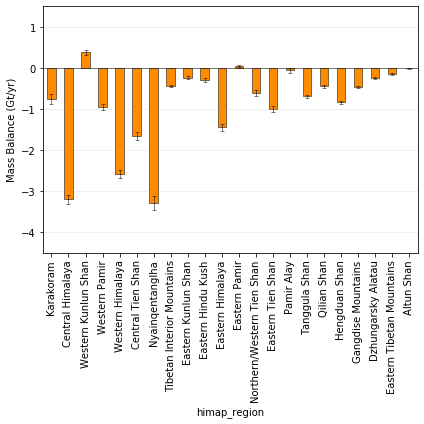

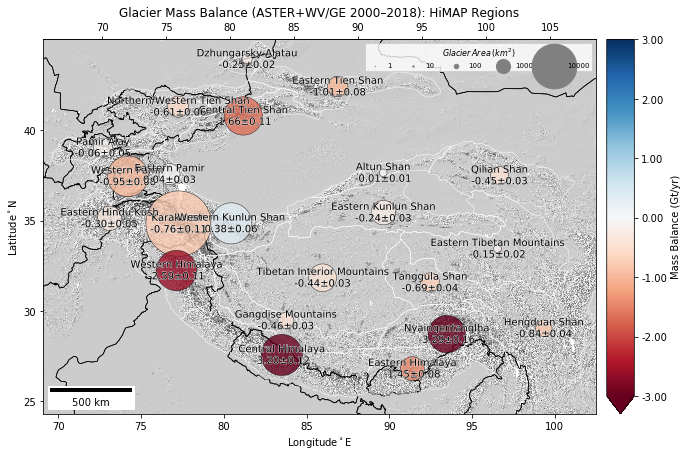

In [579]:
extent = [-1610900, -1142400, 1767400, 1145700]
title = suptitle + ": HiMAP Regions"
glac_gdf_mb_hex_region_agg = hex_agg(glac_gdf_mb_hex, region_df, region_col)
hex_agg_plot(glac_gdf_mb_hex_region_agg, region_df, title, col=col, sigma_col=sigma_col, out_fn_suffix='_hex_himap_region_%s' % mb_unit)

In [580]:
#Number of cells per region
glac_gdf_mb_hex_region_agg['mb_m3wea','sum','size']

himap_region
Karakoram                    153.00
Central Himalaya             173.00
Western Kunlun Shan          129.00
Western Pamir                156.00
Western Himalaya             213.00
Central Tien Shan            120.00
Nyainqentanglha              187.00
Tibetan Interior Mountains   157.00
Eastern Kunlun Shan          131.00
Eastern Hindu Kush           102.00
Eastern Himalaya              95.00
Eastern Pamir                 49.00
Northern/Western Tien Shan   123.00
Eastern Tien Shan             68.00
Pamir Alay                    72.00
Tanggula Shan                 81.00
Qilian Shan                   99.00
Hengduan Shan                106.00
Gangdise Mountains           141.00
Dzhungarsky Alatau            26.00
Eastern Tibetan Mountains     26.00
Altun Shan                    15.00
Name: (mb_m3wea, sum, size), dtype: float64

One-time spatial join by hex
(2415, 65)
Plotting image
Plotting borders
Plotting glacier polygons
Plotting scatterplot of ('mb_Gta', 'sum', 'sum') values
Adding annotations


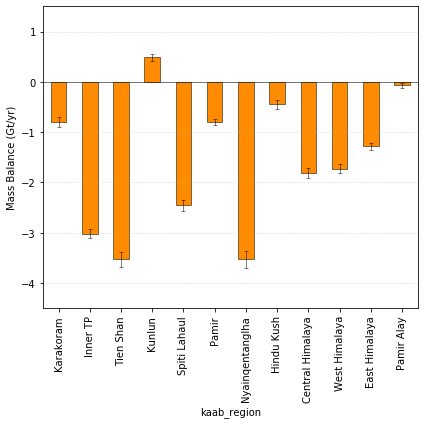

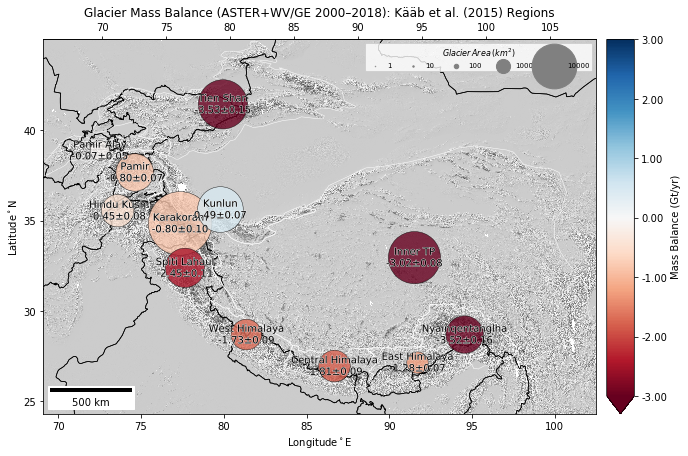

In [581]:
extent = [-1610900, -1142400, 1767400, 1145700]
title = suptitle + ": Kääb et al. (2015) Regions"
glac_gdf_mb_hex_region_agg = hex_agg(glac_gdf_mb_hex, kaab_region_df, kaab_region_col)
hex_agg_plot(glac_gdf_mb_hex_region_agg, kaab_region_df, title, col=col, sigma_col=sigma_col, out_fn_suffix='_hex_kaab_region_%s' % mb_unit)

In [582]:
# Load Brun et al. (2017) numbers for Kaab et al (2015) regions
brun_fn = os.path.join(topdir, 'brun_update.csv')
brun_df = pd.read_csv(brun_fn)
brun_df.set_index('region', inplace=True)
brun_df

orig_mb_mwea  orig_mb_err_mwea  orig_mb_gta  \
region                                                          
East Himalaya            -0.42              0.33        -1.00   
Central Himalaya         -0.33              0.32        -1.60   
Hindu Kush               -0.12              0.14        -0.60   
Inner TP                 -0.14              0.14        -1.80   
Karakoram                -0.03              0.14        -0.50   
Kunlun                    0.14              0.14         1.40   
Nyainqentanglha          -0.62              0.35        -4.00   
Pamir Alay               -0.04              0.14        -0.10   
Pamir                    -0.08              0.14        -0.60   
Spiti Lahaul             -0.37              0.15        -2.90   
Tien Shan                -0.28              0.32        -3.00   
West Himalaya            -0.34              0.15        -1.60   

                  orig_mb_err_gta  new_mb_mwea  new_mb_err_mwea  new_mb_gta  \
region                                                                        
East Himalaya                0.80        -0.42             0.20       -1.00   
Central Himalaya             1.50        -0.33             0.20       -1.60   
Hindu Kush                   0.70        -0.12             0.07       -0.60   
Inner TP                     1.80        -0.14             0.07       -1.80   
Karakoram                    2.50        -0.03             0.07       -0.50   
Kunlun                       1.40         0.14             0.08        1.40   
Nyainqentanglha              2.20        -0.62             0.23       -4.00   
Pamir Alay                   0.30        -0.04             0.07       -0.10   
Pamir                        1.00        -0.08             0.07       -0.60   
Spiti Lahaul                 1.20        -0.37             0.09       -2.90   
Tien Shan                    3.50        -0.28             0.20       -3.00   
West Himalaya                0.70        -0.34             0.09       -1.60   

                  new_mb_err_gta  
region                            
East Himalaya               0.50  
Central Himalaya            1.00  
Hindu Kush                  0.40  
Inner TP                    0.90  
Karakoram                   1.20  
Kunlun                      0.80  
Nyainqentanglha             1.50  
Pamir Alay                  0.10  
Pamir                       0.50  
Spiti Lahaul                0.70  
Tien Shan                   2.20  
West Himalaya               0.40

In [583]:
# Merge
glac_gdf_mb_hex_region_agg_brun = glac_gdf_mb_hex_region_agg.merge(brun_df, left_index=True, right_index=True)

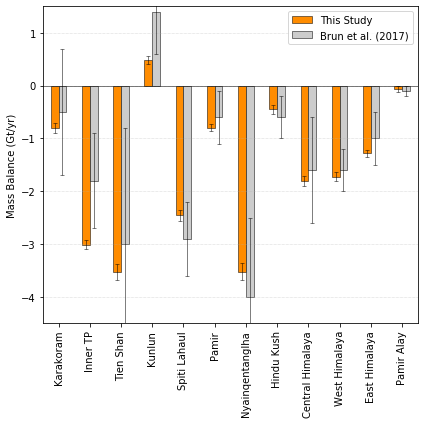

In [584]:
hex_agg_plot(glac_gdf_mb_hex_region_agg_brun, kaab_region_df, title, col=col,sigma_col=sigma_col, out_fn_suffix='_hex_kaab_region_brun_%s' % mb_unit, map=False)

## Basin aggregation and excess meltwater

In [ ]:
basin_melt_gt_clim = (-5, 5)
extent = [-2396534,-2619071,3273634,2008000]
title = suptitle + ": WBM Basins"
out_fn_suffix = '_hex_basin_Gta'
glac_gdf_mb_hex_basin_agg = hex_agg(glac_gdf_mb_hex, basin_df, basin_col)
#hex_agg_plot(glac_gdf_mb_hex_basin_agg, basin_df, title, out_fn_suffix, clim=basin_melt_gt_clim)

Need to aggregate original 25-km cells over union of all ENDO basins for proper RSS uncertainty

In [ ]:
glac_gdf_mb_hex_basin_agg['mb_m3wea','sum','sum']/1E9

In [ ]:
glac_gdf_mb_hex_basin_agg['mb_m3wea_sigma','sum','rss']/1E9

In [ ]:
glac_gdf_mb_hex_basin_agg['mb_m3wea','sum','size']

In [ ]:
glac_gdf_mb_hex_basin_agg['meltwater','total_m3a','sum']/1E9

In [ ]:
glac_gdf_mb_hex_basin_agg['meltwater','total_m3a_sigma','rss']/1E9

In [ ]:
basin_sum = glac_gdf_mb_hex_basin_agg.sum()
basin_sum/1E9

In [ ]:
print('%0.2f\u00b1%0.2f Gt/yr' % (basin_sum[('meltwater_Gta', 'sum','sum')], \
                                  basin_sum[('meltwater_Gta_sigma','sum','rss')]))

In [ ]:
#Exohreic basins
endo_sum = glac_gdf_mb_hex_basin_agg[glac_gdf_mb_hex_basin_agg['ENDO'] == 0].sum()
endo_sum/1E9

In [ ]:
print('%0.2f\u00b1%0.2f Gt/yr' % (endo_sum[('meltwater_Gta', 'sum','sum')], \
                                  endo_sum[('meltwater_Gta_sigma','sum','rss')]))

In [ ]:
endo_sum['mb_Gta','sum','sum']/Gt2mm

In [ ]:
endo_sum['mb_Gta_sigma','sum','rss']/Gt2mm

In [ ]:
18.0*glac_gdf_mb_hex_basin_agg[glac_gdf_mb_hex_basin_agg['ENDO'] == 0].sum()/1E9

In [ ]:
basin_summary = glac_gdf_mb_hex_basin_agg[[('mb_Gta','sum','sum'),('mb_Gta_sigma','sum','rss'),\
                          ('meltwater_Gta','sum','sum'),('meltwater_Gta_sigma','sum','rss')]]
basin_summary['ENDO'] = glac_gdf_mb_hex_basin_agg['ENDO']
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'_hex_basin_summary.pkl'
basin_summary.to_pickle(out_fn)

In [ ]:
basin_melt_gt_clim = (-5, 0)
extent = [-2396534,-2619071,3273634,2008000]
title = suptitle + ": Excess meltwater runoff from glacier mass loss"
out_fn_suffix = '_hex_basin_excess_Gta'
glac_gdf_mb_hex_basin_agg = hex_agg(glac_gdf_mb_hex, basin_df, basin_col)
hex_agg_plot(glac_gdf_mb_hex_basin_agg, basin_df, title, out_fn_suffix, clim=basin_melt_gt_clim, col=('meltwater_Gta','sum','sum'), sigma_col=('meltwater_Gta_sigma','sum','rss'))

In [ ]:
glac_gdf_mb_hex_basin_agg

In [ ]:
basin_summary = glac_df_mb_basin[[('meltwater', 'count'),('meltwater', 'total_m3a'),('meltwater', 'total_Gta'),('meltwater', 'total_mmSLEa'), ('Area_all', 'sum')]]
display(basin_summary)
print(glac_df_mb_basin[[('meltwater', 'total_Gta'),('meltwater', 'total_mmSLEa')]].sum())
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'__%s_basin_summary.pkl' % dt_str
basin_summary.to_pickle(out_fn)

In [ ]:
#Mascons w/ uncertainties

In [ ]:
sigma_clim = (0,0.15)
hex_fig = make_map(col=('mb_Gta_sigma', 'sum', 'rss'), mb_dissolve_df=glac_gdf_mb_hex_region_agg, glac_df_mb=None, \
                   agg_df=region_df, border_df=border_df, clim=sigma_clim, crs=crs, extent=extent, labels=None, title=title)

# Original Analysis

In [ ]:
if kaab_region_shp_fn is not None:
    glac_df_mb_kaab_region = spatial_aggregate(glac_df, glac_df_mb, kaab_region_df, kaab_region_col)

In [ ]:
if region_shp_fn is not None:
    glac_df_mb_region = spatial_aggregate(glac_df, glac_df_mb, region_df, region_col)

In [ ]:
glac_df_mb_kaab_region.iloc[1]

In [ ]:
glac_df_mb_kaab_region[[('Area_all', 'sum'),('mb_Gta', 'sum'),('mb_Gta_sigma', 'sum'),('mb_Gta', 'rss')]]

In [ ]:
mb_tot = glac_df_mb_kaab_region[('mb_m3wea', 'sum')]
DOF=1
#err = glac_df_mb_kaab_region[('mb_m3wea_sigma', 'sum')]/DOF
err = glac_df_mb_kaab_region[('mb_m3wea_sigma', 'rss')]

fig, ax = plt.subplots()
(mb_tot/glac_df_mb_kaab_region[('area_m2', 'sum')]).plot.bar(yerr=err/glac_df_mb_kaab_region[('area_m2', 'sum')], ax=ax, color='darkorange', error_kw=dict(ecolor='k', lw=1, capsize=2, capthick=1))
ax.axhline(0, color='k', lw=0.5)
ax.set_ylabel('Mass Balance (m w.e./yr)')
plt.tight_layout()
fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_mwea_bar.png'
fig.savefig(fig_fn, dpi=300, pad_inches=0) 

fig, ax = plt.subplots()
(mb_tot/1E9).plot.bar(yerr=err/1E9, ax=ax, color='darkorange', error_kw=dict(ecolor='k', lw=1, capsize=2, capthick=1))
ax.axhline(0, color='k', lw=0.5)
ax.set_ylabel('Mass Balance (Gt/yr)')
plt.tight_layout()
fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_Gta_bar.png'
fig.savefig(fig_fn, dpi=300, pad_inches=0) 

In [ ]:
if mascon_shp_fn is not None:
    glac_df_mb_mascon = spatial_aggregate(glac_df, glac_df_mb, mascon_df, mascon_col)

if qdgc_shp_fn is not None:
    glac_df_mb_qdgc = spatial_aggregate(glac_df, glac_df_mb, qdgc_df, qdgc_col)
    
if basin_shp_fn is not None:
    glac_df_mb_basin = spatial_aggregate(glac_df, glac_df_mb, basin_df, basin_col)
    glac_df_mb_basin_exo = glac_df_mb_basin[glac_df_mb_basin['ENDO'] == 0]

In [ ]:
#Compile stats for all glaciers
#specific mass balance rate and total mass change  
all_stats = glac_df_mb[['mb_mwea','mb_m3wea']].mean()
#all_stats = glac_df_mb[['mb_mwea','mb_m3wea']].median()
all_stats['mb_mwea_std'] = glac_df_mb[['mb_mwea','mb_mwea']].std()
all_stats['mb_m3wea_std'] = glac_df_mb[['mb_mwea','mb_m3wea']].std()
#glac_df_mb[['mb_mwea','mb_m3wea']].apply(malib.mad, axis=0)
#all_stats = glac_df_mb[['mb_mwea']].mean()
#Total sampled area
all_stats['sample_area'] = glac_df_mb['Area'].sum()
#All area in RGI db
all_stats['RGI_total_area'] = glac_df['Area'].sum()
all_stats['sample_area_perc'] = all_stats['sample_area']/all_stats['RGI_total_area']
all_stats['mb_m3wea_sum'] = glac_df_mb['mb_m3wea'].sum()
all_stats['mb_m3wea_sigma_mean'] = glac_df_mb['mb_m3wea_sigma'].mean()
all_stats['mb_m3wea_sigma_rss'] = rss(glac_df_mb['mb_m3wea_sigma'])
all_stats['mb_m3wea_sigma_rms'] = rms(glac_df_mb['mb_m3wea_sigma'])
all_stats['mb_m3wea_sigma_sum'] = glac_df_mb['mb_m3wea_sigma'].sum()
all_stats['mb_m3wea_all'] = all_stats['mb_mwea'] * all_stats['RGI_total_area'] * 1E6
all_stats['mb_Gta'] = all_stats['mb_m3wea']/1E9
all_stats['mb_Gta_sum'] = all_stats['mb_m3wea_sum']/1E9
all_stats['mb_Gta_sigma_rss'] = all_stats['mb_m3wea_sigma_rss']/1E9
all_stats['mb_Gta_sigma_rms'] = all_stats['mb_m3wea_sigma_rms']/1E9
all_stats['mb_Gta_all'] = all_stats['mb_m3wea_all']/1E9
all_stats['mma_SLR'] = all_stats['mb_Gta_sum']/Gt2mm

print(all_stats['mb_m3wea_sum']/(all_stats['sample_area']*1E6))
print(all_stats['mb_m3wea_sigma_rss']/(all_stats['sample_area']*1E6))

dt = glac_df_mb['dt'].mean()
all_stats_cum = all_stats * dt

print("All glaciers, rate")
print(all_stats)
#print("All glaciers, cumulative")
#print(all_stats_cum)

In [ ]:
L = 500
n = len(glac_df_mb)
#sigma_rms = all_stats['mb_m3wea_sigma_rms']
#np.sqrt(n)*(5**2)*sigma_rms/1E9
#np.sqrt(n)*sigma_rms/1E9

In [ ]:
n = 30
all_stats['mb_m3wea_sigma_sum']/1E9/np.sqrt(n)

In [ ]:
region_stats = [('mb_mwea', 'count'),('mb_mwea', 'mean'),('mb_mwea', 'std'),('Area', 'sum'),('Area_all', 'sum'),('Area', 'perc'),('mb_mwea', 'total_Gta'), ('mb_Gta', 'sum'), ('mb_Gta', 'rss')]

kaab_region_summary = glac_df_mb_kaab_region[region_stats]
display(kaab_region_summary)
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'__%s_kaab_region_summary.pkl' % dt_str
kaab_region_summary.to_pickle(out_fn)

region_summary = glac_df_mb_region[region_stats]
display(region_summary)
out_fn = os.path.splitext(glac_shp_join_fn)[0]+'__%s_region_summary.pkl' % dt_str
region_summary.to_pickle(out_fn)

#Compile stats for each division
print("\nTotal Gt/a for each aggregation")
print('agg', 'total_Gta', 'mb_mwea')
for i in [glac_df_mb_basin, glac_df_mb_region, glac_df_mb_qdgc]:
    print(i.df_name, i[('mb_Gta', 'sum')].sum(), i['mb_mwea', 'mean'].mean())

if False:
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    print("Loading shaded relief map")
    hs_ds = gdal.Open(hs_fn)
    hs = iolib.ds_getma(hs_ds)
    hs_extent = geolib.ds_extent(hs_ds)
    hs_extent_cartopy = cartopy_extent(hs_extent)
    print("Plotting image")
    ax.imshow(hs, cmap='gray', origin='upper', extent=hs_extent_cartopy, transform=crs, alpha=0.6)
else:
    hs = None

"""
#This is currently broken
import cartopy.feature as cfeature
borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='50m', facecolor='none')
ax.add_feature(borders, edgecolor='k')
"""

In [ ]:
if True:
    mascon_df_out = glac_df_mb_mascon[[('mb_mwea','count'),('mb_mwea', 'mean'), ('mb_mwea', 'std'), ('Area','sum'),('mb_Gta', 'sum'), ('Area_all', 'sum'), ('mb_mwea', 'total_Gta')]]
    header = ('n_glaciers','mb_mwea_mean','mb_mwea_std','obs_glacier_area_km2','mb_Gta_sum','all_glacier_area_km2','mb_Gta_all')
    mascon_csv_fn = os.path.splitext(glac_shp_join_fn)[0]+'_mascon.csv'
    mascon_df_out.to_csv(mascon_csv_fn, float_format='%0.2f',header=header)

In [ ]:
map_plots=True

In [ ]:
if border_shp_fn is not None:
    print("Loading borders")
    #Load local copy of border polygons
    border_df = gpd.read_file(border_shp_fn)
    border_df = border_df.to_crs(glac_df.crs)

In [ ]:
if map_plots and basin_shp_fn is not None:
    basin_melt_gt_clim = (-5, 0)
    basin_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_basin_excess_Gt_fig.png'
    print("Generating figure: %s" % basin_fig_fn)
    if basin_col == 'HYBAS_ID':
        title = suptitle + ": HydroBASINS level 4" 
    else:
        title = suptitle + ": Excess meltwater runoff from Glacier Mass Loss"
    #minx, miny, maxx, maxy
    basin_extent = [-2396534,-2619071, 3273634,2008000]
    #basin_extent = basin_df.total_bounds
    basin_fig = make_map(col=('meltwater', 'total_Gta'), mb_dissolve_df=glac_df_mb_basin, glac_df_mb=glac_df_mb, agg_df=basin_df, border_df=border_df, clim=basin_melt_gt_clim, crs=crs, extent=basin_extent, labels='name+val', title=title)
    #basin_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_basin, glac_df_mb=glac_df_mb, agg_df=basin_df, border_df=border_df, clim=None, crs=crs, extent=extent, labels='val', title=title)
    print("Saving figure: %s" % basin_fig_fn)
    #basin_fig.savefig(basin_fig_fn, **plt_opt) 
    basin_fig.savefig(basin_fig_fn, dpi=300, pad_inches=0) 

In [ ]:
if map_plots and basin_shp_fn is not None:
    basin_mb_clim = (-0.5, 0.5)
    basin_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_basin_mwe_fig.png'
    print("Generating figure: %s" % basin_fig_fn)
    if basin_col == 'HYBAS_ID':
        title = suptitle + ": HydroBASINS level 4" 
    else:
        title = suptitle + ": Basins"
    #minx, miny, maxx, maxy
    basin_extent = [-2396534,-2619071, 3273634,2008000]
    basin_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_basin, glac_df_mb=glac_df_mb, agg_df=basin_df, border_df=border_df, clim=basin_mb_clim, crs=crs, extent=basin_extent, labels='name+val', title=title)
    print("Saving figure: %s" % basin_fig_fn)
    #basin_fig.savefig(basin_fig_fn, **plt_opt) 
    basin_fig.savefig(basin_fig_fn, dpi=300, pad_inches=0) 

In [ ]:
if map_plots and qdgc_shp_fn is not None:
    qdgc_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_qdgc_mwe_fig.png'
    print("Generating figure: %s" % qdgc_fig_fn)
    #To plot grid cells, pass agg_df=qdgc_df
    title = suptitle + ": Quarter-degree Grid Cells"
    qdgc_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_qdgc, glac_df_mb=glac_df_mb, agg_df=None, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels=None, title=title)
    print("Saving figure: %s" % qdgc_fig_fn)
    qdgc_fig.savefig(qdgc_fig_fn, **plt_opt) 

In [ ]:
region_gt_clim = (-3.0, 3.0)
region_mb_clim=(-0.5, 0.5)

if map_plots and kaab_region_shp_fn is not None:
    kaab_region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_Gt_fig.png'
    print("Generating figure: %s" % kaab_region_fig_fn)
    title = suptitle + ": Kaab Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    kaab_region_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_kaab_region, glac_df_mb=glac_df_mb, agg_df=kaab_region_df, border_df=border_df, clim=region_gt_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % kaab_region_fig_fn)
    kaab_region_fig.savefig(kaab_region_fig_fn, **plt_opt) 

    kaab_region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_kaab_region_mwe_fig.png'
    print("Generating figure: %s" % kaab_region_fig_fn)
    title = suptitle + ": Kaab Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    kaab_region_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_kaab_region, glac_df_mb=glac_df_mb, agg_df=kaab_region_df, border_df=border_df, clim=region_mb_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % kaab_region_fig_fn)
    kaab_region_fig.savefig(kaab_region_fig_fn, **plt_opt) 

In [ ]:
if map_plots and region_shp_fn is not None:
    region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_region_Gt_fig.png'
    print("Generating figure: %s" % region_fig_fn)
    title = suptitle + ": Himap Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    region_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=region_gt_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % region_fig_fn)
    region_fig.savefig(region_fig_fn, **plt_opt) 

    region_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_region_mwe_fig.png'
    print("Generating figure: %s" % region_fig_fn)
    title = suptitle + ": Himap Regions"
    #region_fig = make_map(col='mb_mwea', mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels='name+val')
    region_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_region, glac_df_mb=glac_df_mb, agg_df=region_df, border_df=border_df, clim=region_mb_clim, crs=crs, extent=extent, labels='name+val', title=title)
    print("Saving figure: %s" % region_fig_fn)
    region_fig.savefig(region_fig_fn, **plt_opt) 

In [ ]:
if map_plots and mascon_shp_fn is not None:
    mascon_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_mascon_mwe_fig.png'
    print("Generating figure: %s" % mascon_fig_fn)
    #To plot grid cells, pass agg_df=mascon_df
    title = suptitle + ": GSFC GRACE Mascons"
    mascon_fig = make_map(col=('mb_mwea', 'mean'), mb_dissolve_df=glac_df_mb_mascon, glac_df_mb=glac_df_mb, agg_df=None, border_df=border_df, clim=mb_clim, crs=crs, extent=extent, labels=None, title=title)
    print("Saving figure: %s" % mascon_fig_fn)
    mascon_fig.savefig(mascon_fig_fn, **plt_opt) 

In [ ]:
if map_plots and mascon_shp_fn is not None:
    mascon_gt_clim = (-0.5, 0.5)
    mascon_fig_fn = os.path.splitext(glac_shp_join_fn)[0]+'_mascon_Gt_fig.png'
    print("Generating figure: %s" % mascon_fig_fn)
    #To plot grid cells, pass agg_df=mascon_df
    title = suptitle + ": GSFC GRACE Mascons"
    mascon_fig = make_map(col=('mb_Gta', 'sum'), mb_dissolve_df=glac_df_mb_mascon, glac_df_mb=glac_df_mb, agg_df=None, border_df=border_df, clim=mascon_gt_clim, crs=crs, extent=extent, labels=None, title=title)
    print("Saving figure: %s" % mascon_fig_fn)
    mascon_fig.savefig(mascon_fig_fn, **plt_opt) 